In [1]:
# !apt update -qq && apt install -qq graphviz -y && apt clean && apt autoclean && apt autoremove -yqq
# pip install --upgrade --no-cache-dir pip wheel setuptools black isort jupyterlab-code-formatter jupyterthemes jupyterlab_darkside_theme nvitop ipykernel jupyterlab
# pip install --upgrade --no-cache-dir torch --index-url https://download.pytorch.org/whl/cu128
# pip install --upgrade --no-cache-dir tensorboard accelerate flash-attn torchtnt bitsandbytes transformers
# pip install --upgrade --no-cache-dir torcheval torchmetrics torchtnt
# pip install --upgrade --no-cache-dir optuna
# pip install --upgrade --no-cache-dir torchviz
# pip install  --upgrade --no-cache-dir scikit-learn scikit-learn-intelex
# !rm ~/.cache/matplotlib -rf

In [2]:
import datetime
import os
import pickle
import warnings
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
from copy import deepcopy
from gc import collect
from glob import glob
from pprint import pprint
from typing import Dict

from sklearn.cluster import *
from sklearn.metrics import davies_bouldin_score

warnings.simplefilter(action="ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import torch
import torchmetrics
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, StandardScaler

# from sklearnex import patch_sklearn
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

# patch_sklearn()
tqdm.pandas()
seed = 42
import random

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


def _collect():
    x = 0
    for i in range(3):
        x += collect()
        torch.cuda.empty_cache()
    return x


# Using 1 year of history data (52 weeks)
window = 52
# Predicting out 8 weeks
n_out = 16
# early_stop = {"patience": 15, "min_delta": 0.5 * (window * 2) / 10}
resample_period = "1W"
dataset_type = "df_sales"
# Retain only SKU that have at least 10% of data [(1 - max_zeros_in_sku) * 100]
max_zeros_in_sku = 0.7

In [3]:
%matplotlib inline

In [4]:
col_to_remove = [
    "amt_disc_ea",
    "amt_gross",
    "amt_net",
    "amt_net_forex",
    "canceled",
    "class_code",
    "code",
    "color_code",
    "cost_center",
    "created_at",
    "currency",
    "customer_code",
    "deleted_at",
    "department_code",
    "discount_granted_excl",
    "discountflag",
    "document_currency",
    "document_number",
    "document_type",
    "family_code",
    "filename",
    "flag_delete",
    "gender_code",
    "geography",
    "gl_account",
    "gl_devise",
    "gl_etablissement",
    "gl_model",
    "gl_numero",
    "gl_numligne",
    "gl_puht",
    "gl_refartbarre",
    "gl_remiseligne",
    "gl_tiers",
    "gl_totalht",
    "gp_refexterne",
    "division",
    "group_code",
    "id",
    "id_class",
    "id_collection",
    "id_color",
    "id_department",
    "id_family",
    "id_gender",
    "id_group",
    "id_loader_job",
    "id_subclass",
    "libdim1",
    "pays",
    "price_ea",
    "product_id",
    "rate",
    "rn",
    "subclass_code",
    "upc",
]

In [5]:
# def load_raw_df(
#     glob_filter: str = "df_sales*.parquet",
#     columns_rename: dict = {
#         "gl_datepiece": "date",
#         "gl_codearticle": "sku",
#         "gl_qtefact": "qty",
#     },
# ):
#     df: pd.DataFrame = pd.concat([pd.read_parquet(f) for f in glob(glob_filter)])
#     # Removing unuseful columns
#     [df.pop(col) for col in col_to_remove if col in df]
#     # Renaming columns
#     df = df.reset_index(drop=True).rename(columns=columns_rename)

#     df["date"] = pd.to_datetime(df["date"])
#     df = df.convert_dtypes()

#     # Strip text data
#     for column in df.select_dtypes(include=[pd.StringDtype]).columns:
#         df[column] = df[column].str.strip()

#     # Removing null/wrong SKUs - data cleaning on qty
#     df = df[~df["sku"].isna()]
#     df = df[df["sku"].str.contains(r"\b\w{7}-\w{5}-\w{3}\b")]
#     df = df[df["qty"] > 0]

#     df["sales_type"] = (
#         glob_filter.split("*")[0] if "*" in glob_filter else glob_filter.split(".")[0]
#     )
#     return df

In [6]:
# raw_dataset_fname = "raw_dataset.parquet"

# if os.path.exists(raw_dataset_fname):
#     df = pd.read_parquet(raw_dataset_fname)
#     # Retain only cegid sales
#     df = df[df["sales_type"] == "df_sales"]
#     dataset_type = "_".join(df["sales_type"].unique())
#     del df["sales_type"]
#     if "date" in df:
#         df.set_index("date", inplace=True)
#     df = df.copy()
# else:
#     df_cl1 = load_raw_df(
#         "cl1_sales*.parquet",
#         {"posting_date": "date", "product_color": "sku", "quantity": "qty"},
#     )
#     df_sales = load_raw_df(
#         "df_sales*.parquet",
#         {"gl_datepiece": "date", "gl_codearticle": "sku", "gl_qtefact": "qty"},
#     )
#     df = pd.concat([df_sales, df_cl1])
#     df.sort_values("date", inplace=True)
#     df.to_parquet(raw_dataset_fname, compression="brotli")
#     df.set_index("date", inplace=True)

In [7]:
# df = pd.read_csv("sklearnFakeData.csv")
df = pd.read_csv("sklearnFakeData_v2.csv")
df["date"] = pd.to_datetime(df["date"])
df.rename(columns={"product_id": "sku", "sales_qty": "qty"}, inplace=True)
df.set_index("date", inplace=True)
df = df.convert_dtypes()
display(df)

store_id         sku  qty  price  stock  discount  is_promo_day  \
date                                                                          
2020-01-01   store_4   product_0    1  51.98    497      0.01         False   
2020-01-01   store_9  product_32  564  46.68    570      0.05          True   
2020-01-01  store_11  product_69  240  61.05    258       0.1         False   
2020-01-01   store_2  product_88    0  50.19    355      0.01         False   
2020-01-01  store_19  product_45    0  45.78    521       0.0         False   
...              ...         ...  ...    ...    ...       ...           ...   
2023-12-30   store_3  product_66  502  52.38    613      0.02         False   
2023-12-30  store_16  product_66   92  52.38    613      0.02         False   
2023-12-30  store_11  product_66  653  52.38    613      0.02         False   
2023-12-30  store_10  product_66  983  52.38    613      0.02          True   
2023-12-30  store_13  product_99    0  63.94    445      0.12          True   

            color size category subcategory  
date                                         
2020-01-01    red    S  costume           C  
2020-01-01    red    S    shoes           E  
2020-01-01  green    M      bag           C  
2020-01-01  green    S      bag           D  
2020-01-01  white    L     suit           B  
...           ...  ...      ...         ...  
2023-12-30   blue   XL    dress           C  
2023-12-30   blue   XL    dress           C  
2023-12-30   blue   XL    dress           C  
2023-12-30   blue   XL    dress           C  
2023-12-30    red    M    dress           F  

[2920000 rows x 11 columns]

# Feature engineering
#### Time
 - Decompose in `t_sin` and `t_cos`
#### Seasons
 - Split `market_seasons` by `|` and concat with `seasons`, `market_season`, `season`
#### Sizes
 - Split `sizes` by `|` and concat with `size`
#### Channels
 - Split `channels` by `|` and concat with `channel`
#### Brands
 - Split `brands` by `|` and concat with `brand`
#### Collections
 - Split `collections` by `|` and concat with `collections`

In [8]:
import tsfresh

/opt/SP/SDK/miniforge3/envs/ml/lib/python3.12/site-packages/tsfresh/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [9]:
# def get_features(df: pd.DataFrame, col_feature: str):
#     features = []
#     # Filtering all columns that contains our `col_feature` target
#     cols = [col for col in df if col_feature in col]
#     for col in cols:
#         unique_values = [v for v in df.pop(col).unique() if not pd.isnull(v)]

#         for value in unique_values:
#             features.extend([v.strip() for v in value.split("|")])
#     features = [f for f in list(set(features)) if len(f) > 0]
#     df[col_feature] = [features for _ in range(len(df))]

In [10]:
# raw_ts_fname = f"raw_timeseries_{dataset_type}_{resample_period}.parquet"
# if os.path.exists(raw_ts_fname):
#     series = pd.read_parquet(raw_ts_fname)
#     if "date" in series:
#         series.set_index("date", inplace=True)
# else:
#     series_list = []
#     for sku, _df in tqdm(df.groupby("sku")):
#         agg = dict(zip(_df.keys(), ["last"] * len(_df.columns))) | {"qty": "sum"}
#         _series = _df.resample(resample_period).agg(agg).ffill().bfill()
#         [
#             get_features(_series, feature)
#             for feature in ["size", "season", "channel", "brand", "collection"]
#         ]
#         series_list.append(_series)
#     series = pd.concat(series_list).sort_index()
#     series.to_parquet(raw_ts_fname, compression="brotli")

In [11]:
series_list = []
for _, _df in tqdm(df.groupby(["sku", "store_id"])):
    agg = dict(zip(_df.keys(), ["last"] * len(_df.columns))) | {"qty": "sum"}
    _series = _df.resample(resample_period).agg(agg).ffill().bfill()
    # [
    #     get_features(_series, feature)
    #     for feature in ["size", "season", "channel", "brand", "collection"]
    # ]
    series_list.append(_series)
series = pd.concat(series_list).sort_index()
series.to_parquet("timeseries.parquet", compression="brotli")
print(
    f"Resampled {len(df)} entries ({df['sku'].nunique()} total products) into {len(series)} entries"
)

  0%|          | 0/1315 [00:00<?, ?it/s]

Resampled 2920000 entries (100 total products) into 274835 entries


In [12]:
mask = series.isna().any(axis=1)
print(
    f"Removing {len(series.loc[mask, 'sku'].unique())} SKU that does not have categorical data [{mask.sum()}] weeks"
)
series = series[~mask].copy()

Removing 0 SKU that does not have categorical data [0] weeks


In [13]:
# Removing SKUs that do not have at least:
# - 1 example for train and 1 for test
# - 90% of empty data


def filter_sku(df):
    """Filters a single product based on length and zero percentage."""
    if len(df) < (window + n_out + 2):
        return False  # Too short
    zero_percentage = (df["qty"] == 0).sum() / len(df)
    return zero_percentage < max_zeros_in_sku


filter_fields = ["sku", "store_id"]
entries_to_retain = (
    series.groupby(filter_fields)
    .filter(filter_sku)[filter_fields]
    .reset_index(drop=True)
    .drop_duplicates()
)


from functools import reduce


masks = []
for _, vs in tqdm(
    entries_to_retain.iterrows(), position=0, total=len(entries_to_retain)
):
    vs = vs.to_dict()
    minimask = []
    for k, v in vs.items():
        minimask.append(series[k] == v)
    masks.append(reduce(np.logical_and, minimask))
mask = reduce(np.logical_or, masks)

series[~mask].sort_values(filter_fields).to_csv("dataset/removed_entries.csv")

_percent_retained = round(
    len(entries_to_retain) / len(series[filter_fields].drop_duplicates()) * 100, 2
)
_percent_entries_retained = round(((mask).sum() / len(series)) * 100, 2)
print(
    f"Retained {_percent_retained}% of SKUs [{_percent_entries_retained}% total entries]"
)
series = series[mask].copy()

  0%|          | 0/1315 [00:00<?, ?it/s]

Retained 100.0% of SKUs [100.0% total entries]


In [14]:
sku_to_index = {sku: idx for idx, sku in enumerate(df["sku"].unique())}
series["sku_code"] = series["sku"].map(sku_to_index)
features = {}
series["qty"] = series["qty"].astype(float)

# from tsfresh.feature_extraction import EfficientFCParameters
# default_fc_params = EfficientFCParameters()
# for label, group in tqdm(series.groupby(["sku_code", "store_id"])):
#     features[label] = tsfresh.extract_features(group.reset_index(),column_id='sku_code',column_value='qty',column_sort='date',disable_progressbar=True,default_fc_parameters=default_fc_params)

In [15]:
# import pickle

# with open("metafeatures.pkl", "wb") as f:
#     pickle.dump(features, f)

In [16]:
# metafeatures_scaler = StandardScaler()
# metafeatures_df = pd.DataFrame()
# for k, v in features.items():
#     v["sku_code"] = k[0]
#     v["store_id"] = k[1]
#     metafeatures_df = pd.concat([metafeatures_df, v])
# metafeatures_df.replace(0,pd.NA,inplace=True)
# metafeatures_df.dropna(axis=1, how="all", inplace=True)
# metafeatures_df.fillna(0, inplace=True)
# metafeatures_columns = [
#     c
#     for c in metafeatures_df.select_dtypes(np.number).columns
#     if c not in set(df.columns)
# ]

# metafeatures_df.loc[:, metafeatures_columns] = metafeatures_scaler.fit_transform(
#     metafeatures_df[metafeatures_columns]
# )

In [17]:
# metafeatures_df.to_csv('series_metafeatures.csv',index=False)
metafeatures_df = pd.read_csv("series_metafeatures.csv")
if "Unnamed: 0" in metafeatures_df:
    metafeatures_df.pop("Unnamed: 0")
metafeatures_df

qty__has_duplicate_max  qty__sum_values  qty__abs_energy  \
0                  -0.087538        -0.445474        -0.203951   
1                  -0.087538        -0.445797        -0.203951   
2                  -0.087538        -0.436831        -0.203849   
3                  -0.087538        -0.412101        -0.203623   
4                  -0.087538        -0.425975        -0.203653   
...                      ...              ...              ...   
1310               -0.087538         0.246152         0.096587   
1311               -0.087538         0.253807         0.113391   
1312               -0.087538        -0.235156        -0.171984   
1313               -0.087538         0.109795         0.018531   
1314               -0.087538         0.048229        -0.039735   

      qty__mean_abs_change  qty__mean_change  \
0                -0.545309         -0.016048   
1                -0.546166         -0.012944   
2                -0.527088         -0.009839   
3                -0.526872         -0.009841   
4                -0.503581         -0.008804   
...                    ...               ...   
1310              1.228123         -0.016048   
1311              1.238812         -1.714458   
1312             -0.007453         -0.128862   
1313              0.889237         -0.016048   
1314              0.720370         -0.412447   

      qty__mean_second_derivative_central  qty__median  qty__mean  \
0                               -0.023695    -0.419134  -0.532036   
1                               -0.019604    -0.419134  -0.532652   
2                               -0.041697    -0.413856  -0.515538   
3                               -0.017971    -0.408577  -0.511318   
4                               -0.016331    -0.398021  -0.494819   
...                                   ...          ...        ...   
1310                            -1.942446    -0.429691   0.788031   
1311                             1.176648    -0.429691   0.802642   
1312                            -0.278983    -0.429691  -0.130614   
1313                            -4.818525    -0.429691   0.527773   
1314                            -1.015391    -0.429691   0.410266   

      qty__length  qty__standard_deviation  ...  \
0       -0.698104                -0.565127  ...   
1       -0.698104                -0.565096  ...   
2       -0.698104                -0.547506  ...   
3        0.642052                -0.542760  ...   
4       -0.698104                -0.526427  ...   
...           ...                      ...  ...   
1310    -0.698104                 1.418482  ...   
1311    -0.698104                 1.480943  ...   
1312    -0.698104                 0.070220  ...   
1313    -0.698104                 1.160608  ...   
1314    -0.698104                 0.903564  ...   

      qty__fourier_entropy__bins_10  qty__fourier_entropy__bins_100  \
0                         -1.364767                       -1.176760   
1                         -0.368002                       -0.721414   
2                         -0.539000                       -0.683506   
3                          1.937690                        1.503122   
4                         -1.387200                       -1.274149   
...                             ...                             ...   
1310                       1.102312                        0.262754   
1311                      -0.962460                       -1.038911   
1312                       0.237607                       -0.093463   
1313                       0.193265                        0.461724   
1314                      -0.393600                       -0.161977   

      qty__permutation_entropy__dimension_3__tau_1  \
0                                         0.537523   
1                                         0.493204   
2                                         0.576678   
3                                         0.587972   
4                                         0.646917   
...              

In [18]:
def create_timeseries(X, cat, y, window=10, n_out=1, shift=0):
    _X, _cat, _y = [], [], []
    for i in range(len(X) - (window + n_out + shift)):
        _X.append(X[i : i + window])
        _cat.append(cat[i])
        _y.append(y[i + window + shift : i + window + shift + n_out])
    return np.asarray(_X), np.asarray(_cat), np.asarray(_y)


example_data = np.asarray(range(10))
print(example_data)
_x, _cat, _y = create_timeseries(example_data, example_data, example_data, 3, 1, 0)
print(train_test_split(_x, _cat, _y, shuffle=False))
# print(train_test_split(_x, _cat, _y, shuffle=True))
_x.shape, _cat.shape, _y.shape, _x, _cat, _y

[0 1 2 3 4 5 6 7 8 9]
[array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]]), array([[4, 5, 6],
       [5, 6, 7]]), array([0, 1, 2, 3]), array([4, 5]), array([[3],
       [4],
       [5],
       [6]]), array([[7],
       [8]])]


((6, 3),
 (6,),
 (6, 1),
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6],
        [5, 6, 7]]),
 array([0, 1, 2, 3, 4, 5]),
 array([[3],
        [4],
        [5],
        [6],
        [7],
        [8]]))

In [19]:
max_value = series["qty"].max()
for dtype in [np.float16, np.float32, np.float64]:
    if max_value <= np.finfo(dtype).max:
        print(f"Setting dtype: {dtype}")
        series["qty"] = series["qty"].astype(dtype)
        break

Setting dtype: <class 'numpy.float32'>


In [20]:
_max = 0
_sku = ""
for sku, group in series.groupby("sku"):
    v = group["qty"].max() - group["qty"].mean()
    if v > _max:
        _sku = sku
sku

'product_99'

<Axes: xlabel='date'>

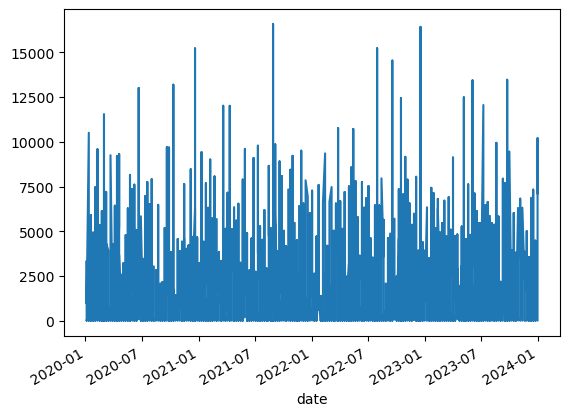

In [21]:
# outlier_sku = "MWL150E-00139-100"
# outlier_sku = series[series['qty'] == series['qty'].max()].iloc[0]['sku']
_mask = series["sku"] == _sku
data = series.loc[_mask, "qty"]
data.plot()

In [22]:
def remove_outliers(data: pd.Series, n=3) -> tuple[pd.Series, bool]:
    # Calculate Z-scores
    mean = data.mean()
    std = data.std()
    data_zscore = (data - mean) / std

    # Identify outliers (e.g., |Z| > 3)
    outliers_z = data[abs(data_zscore) > n]
    has_outliers = len(outliers_z) > 0
    clip_data = data
    if has_outliers:
        clip_data = data.clip(upper=mean + n * std, lower=mean - n * std)

    return clip_data, has_outliers

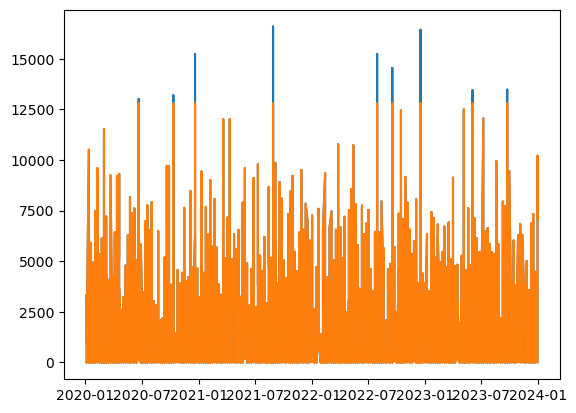

In [23]:
_data, has_outliers = remove_outliers(data.astype(float), n=5)
plt.plot(data)
plt.plot(_data)

In [24]:
filtered_ts_fname = f"dataset/filtered_timeseries_{dataset_type}_{resample_period}_{max_zeros_in_sku}_{window}_{n_out}.parquet"
# if os.path.exists(filtered_ts_fname):
#     series = pd.read_parquet(filtered_ts_fname)
# else:
n_outliers = 0
for sku in tqdm(series["sku"].unique()):
    mask = series["sku"] == sku
    data, has_outliers = remove_outliers(series.loc[mask, "qty"], n=5)
    if has_outliers:
        n_outliers += 1
        series.loc[mask, "qty"] = data
print(f"Removed {n_outliers} outliers")
series = series.convert_dtypes()
# series.to_parquet(filtered_ts_fname, compression="brotli")

  0%|          | 0/100 [00:00<?, ?it/s]

Removed 91 outliers


  0%|          | 0/10 [00:00<?, ?it/s]

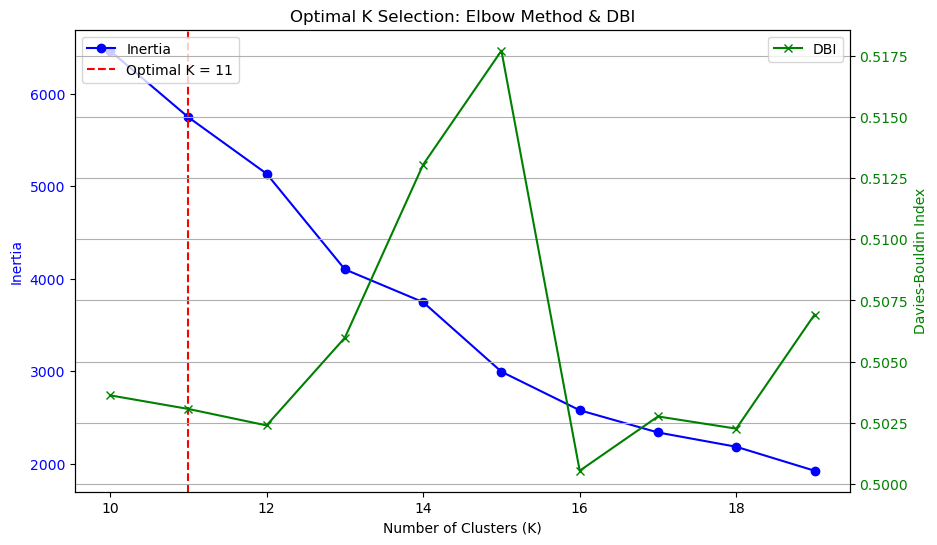

Optimal K: 11


In [25]:
def find_best_k(data, k_range=range(10, 20), random_state=42):
    inertia_values = []
    dbi_scores = []

    for k in tqdm(k_range):
        kmeans = KMeans(n_clusters=k, random_state=random_state, max_iter=1000, tol=1e6)
        kmeans.fit(data)
        inertia_values.append(kmeans.inertia_)
        dbi_scores.append(davies_bouldin_score(data, kmeans.labels_))

    # Determine the "elbow point" for inertia
    deltas = np.diff(inertia_values)
    elbow_point = np.argmin(np.diff(deltas)) + k_range.start  # Adjust for indexing

    # Plot the Elbow Method and DBI
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Inertia plot
    ax1.plot(k_range, inertia_values, marker="o", label="Inertia", color="blue")
    ax1.set_xlabel("Number of Clusters (K)")
    ax1.set_ylabel("Inertia", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")

    # DBI plot
    ax2 = ax1.twinx()
    ax2.plot(k_range, dbi_scores, marker="x", label="DBI", color="green")
    ax2.set_ylabel("Davies-Bouldin Index", color="green")
    ax2.tick_params(axis="y", labelcolor="green")

    # Highlight the optimal K
    ax1.axvline(
        x=elbow_point, color="red", linestyle="--", label=f"Optimal K = {elbow_point}"
    )
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.title("Optimal K Selection: Elbow Method & DBI")
    plt.grid()
    plt.show()

    return {
        "kmeans": KMeans(
            n_clusters=elbow_point, random_state=random_state, max_iter=1000, tol=1e6
        ),
        "best_k": elbow_point,
        "inertia_values": inertia_values,
        "dbi_scores": dbi_scores,
    }


scaler = StandardScaler()
series["qty_scaled"] = scaler.fit_transform(series["qty"].to_frame())
cluster_results = find_best_k(series[["qty_scaled"]])
print("Optimal K:", cluster_results["best_k"])
kmeans = cluster_results["kmeans"]
series["bins"] = kmeans.fit_predict(series[["qty_scaled"]])

# Creating categorical features

In [26]:
cols = set(series.select_dtypes(np.number).columns)

categorical_features = [c for c in series.columns if c not in cols and "sku" not in c]
categorical_features.extend(["bins"])
categorical_features

['store_id',
 'is_promo_day',
 'color',
 'size',
 'category',
 'subcategory',
 'bins']

In [27]:
from sklearn.preprocessing import OneHotEncoder

label_encoders = {c: MultiLabelBinarizer() for c in categorical_features} | {
    "bins": OneHotEncoder(sparse_output=False, dtype=int),  # LabelBinarizer(),
    "is_promo_day": OneHotEncoder(
        sparse_output=False, dtype=int
    ),  # For boolean flag need to automatically get OneHot instead of label/multilabel
    "store_id": OneHotEncoder(sparse_output=False, dtype=int),
}
label_encoders

{'store_id': OneHotEncoder(dtype=<class 'int'>, sparse_output=False),
 'is_promo_day': OneHotEncoder(dtype=<class 'int'>, sparse_output=False),
 'color': MultiLabelBinarizer(),
 'size': MultiLabelBinarizer(),
 'category': MultiLabelBinarizer(),
 'subcategory': MultiLabelBinarizer(),
 'bins': OneHotEncoder(dtype=<class 'int'>, sparse_output=False)}

In [28]:
for column, label_encoder in tqdm(label_encoders.items()):
    if "is_promo_day" in column or "bins" in column or "store" in column:
        series[f"encoded_{column}"] = label_encoder.fit_transform(
            series[column].reset_index(drop=True).to_frame()
        ).tolist()
    else:
        series[f"encoded_{column}"] = label_encoder.fit_transform(
            series[column].reset_index(drop=True)
        ).tolist()
    #  = label_encoder.transform(
    #     series[column].reset_index(drop=True)
    # ).tolist()

  0%|          | 0/7 [00:00<?, ?it/s]

In [29]:
store_id_map = dict(
    pd.concat(
        [series["store_id"], series["encoded_store_id"].apply(lambda x: np.argmax(x))],
        axis=1,
    )
    .drop_duplicates()
    .values
)
store_id_map

{'store_0': 0,
 'store_15': 7,
 'store_10': 2,
 'store_18': 10,
 'store_14': 6,
 'store_17': 9,
 'store_2': 12,
 'store_6': 16,
 'store_3': 13,
 'store_1': 1,
 'store_5': 15,
 'store_8': 18,
 'store_9': 19,
 'store_19': 11,
 'store_7': 17,
 'store_4': 14,
 'store_11': 3,
 'store_13': 5,
 'store_16': 8,
 'store_12': 4}

<Axes: xlabel='date'>

<Axes: xlabel='date'>

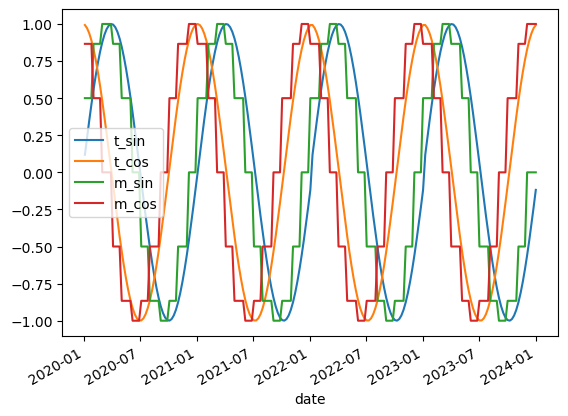

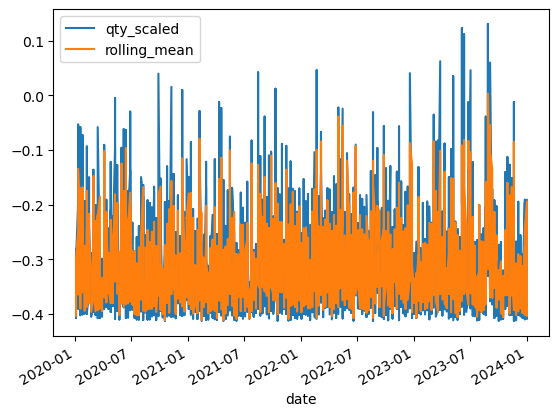

In [30]:
# Create time features. Decompose the time "signal" using cos and sin coordinates.
# By this, the first week of the year is nearest point of the last week instead of the farthest.
# FIXME: We use only the week number (1-52 i think), add features related to holiday and month instead of the week number only)
# FIXME: Take care about the COVID period in order to add an external bias factor for influence the 2020-2022 sales.
#   Note that batch size can influence the generalization of the network and reduce the sales due to the decrease of the sales.
calendar = series.index.isocalendar().week
series["t_sin"] = np.sin(calendar * (2 * np.pi / calendar.max()))
series["t_cos"] = np.cos(calendar * (2 * np.pi / calendar.max()))

series["m_sin"] = np.sin(series.index.month * (2 * np.pi / series.index.month.max()))
series["m_cos"] = np.cos(series.index.month * (2 * np.pi / series.index.month.max()))


display(series[series["sku"] == sku][["t_sin", "t_cos", "m_sin", "m_cos"]].plot())
t = series[series["sku"] == sku][["qty_scaled"]]
t["rolling_mean"] = t["qty_scaled"].rolling(2).mean()
t.plot()

In [31]:
series_fname = (
    f"dataset/series_{dataset_type}_{max_zeros_in_sku}_{window}_{n_out}_with_bins.pkl"
)
# if os.path.exists(series_fname):
#     with open(series_fname, "rb") as f:
#         (
#             ts_train_x_dataset,
#             ts_train_cat_dataset,
#             ts_train_y_dataset,
#             ts_test_x_dataset,
#             ts_test_cat_dataset,
#             ts_test_y_dataset,
#         ) = pickle.load(f)
# else:
ts_train_x_dataset = []
ts_train_cat_dataset = []
ts_train_y_dataset = []
ts_test_x_dataset = []
ts_test_cat_dataset = []
ts_test_y_dataset = []
grouped = series.groupby(["sku_code", "store_id"])
encoded_categorical_features = [
    c for c in series.columns if "encoded" in c and "bins" not in c
]
series_features = [
    "qty_scaled",
    "sku_code",
    "t_sin",
    "t_cos",
    "m_sin",
    "m_cos",
]
series_features.extend(
    [
        c
        for c in series.select_dtypes(np.number)
        if c.startswith("qty_") and c not in set(series_features)
    ]
)


def process_group(_series, window, n_out):
    categorical_data = (
        _series[encoded_categorical_features]
        .iloc[0]
        .apply(lambda x: np.asarray(x, dtype=np.bool_))
        .values
    )
    _ts, _cat, _y = create_timeseries(
        _series[series_features].values,
        [categorical_data] * len(_series),
        _series[["qty_scaled", "encoded_bins"]].values,
        window=window,
        n_out=n_out,
    )
    return train_test_split(_ts, _cat, _y, test_size=0.2, shuffle=False)


results = []
with ThreadPoolExecutor() as executor:
    for idx, (sku, _series) in enumerate(tqdm(grouped)):
        results.append(executor.submit(process_group, _series, window, n_out))

for future in tqdm(results):
    _ts_train, _ts_test, _cat_train, _cat_test, _y_train, _y_test = future.result()
    ts_train_x_dataset.extend(_ts_train)
    ts_test_x_dataset.extend(_ts_test)
    ts_train_cat_dataset.extend(_cat_train)
    ts_test_cat_dataset.extend(_cat_test)
    ts_train_y_dataset.extend(_y_train)
    ts_test_y_dataset.extend(_y_test)

ts_train_x_dataset = np.asarray(ts_train_x_dataset)
ts_train_y_dataset = np.asarray(ts_train_y_dataset)
ts_train_cat_dataset = np.asarray(ts_train_cat_dataset)
ts_test_x_dataset = np.asarray(ts_test_x_dataset)
ts_test_y_dataset = np.asarray(ts_test_y_dataset)
ts_test_cat_dataset = np.asarray(ts_test_cat_dataset)
# with open(series_fname, "wb") as f:
#     pickle.dump(
#         (
#             ts_train_x_dataset,
#             ts_train_cat_dataset,
#             ts_train_y_dataset,
#             ts_test_x_dataset,
#             ts_test_cat_dataset,
#             ts_test_y_dataset,
#         ),
#         f,
#         pickle.HIGHEST_PROTOCOL,
#     )
# del series
_collect()
ts_train_x_dataset.shape, ts_train_cat_dataset.shape, ts_train_y_dataset.shape

  0%|          | 0/1315 [00:00<?, ?it/s]

  0%|          | 0/1315 [00:00<?, ?it/s]

((147280, 52, 6), (147280, 6), (147280, 16, 2))

In [32]:
# scaler_x = StandardScaler().fit(ts_train_x_dataset[:, :, 0])
# scaler_y = StandardScaler().fit(ts_train_y_dataset[:, :, 0])

# ts_train_x_dataset[:, :, 0] = scaler_x.transform(ts_train_x_dataset[:, :, 0])
# ts_test_x_dataset[:, :, 0] = scaler_x.transform(ts_test_x_dataset[:, :, 0])
# ts_train_y_dataset[:, :, 0] = scaler_y.transform(ts_train_y_dataset[:, :, 0])
# ts_test_y_dataset[:, :, 0] = scaler_y.transform(ts_test_y_dataset[:, :, 0])

In [33]:
for x, cat, y in zip(ts_test_x_dataset, ts_test_cat_dataset, ts_test_y_dataset):
    print(x.shape, [_.shape for _ in cat], y.shape)
    break

(52, 6) [(20,), (2,), (15,), (4,), (15,), (6,)] (16, 2)


In [34]:
features = defaultdict(dict)
feature_cols = list(set([c for c in metafeatures_df.columns if c.startswith("qty")]))
for sku_code, sku_group in tqdm(metafeatures_df.groupby("sku_code")):
    feature = {}
    for _store_id, store_group in sku_group.groupby("store_id"):
        store_id = store_id_map[_store_id]
        feature[store_id] = list(
            store_group[feature_cols].to_dict(orient="records")[0].values()
        )
    features[sku_code] = feature
n_metafeatures = len(features[sku_code][store_id])

  0%|          | 0/100 [00:00<?, ?it/s]

In [35]:
class DemandDataset(Dataset):
    def __init__(self, raw_dataset, cat_dataset, y, features):
        self.raw_dataset = raw_dataset
        self.cat_dataset = cat_dataset
        self.y = y
        self.metafeatures = features

    def __len__(self):
        return len(self.raw_dataset)

    def __getitem__(self, idx):
        return {
            "sequence": self.raw_dataset[idx],
            "y": self.y[idx],
            "categorical_data": self.cat_dataset[idx],
        }

    def collate_fn(self, batch):
        qty = torch.as_tensor(
            np.asarray([x["sequence"][:, 0] for x in batch], dtype=np.float32),
            dtype=torch.float32,
        ).unsqueeze(-1)
        skus = torch.as_tensor(
            np.asarray([x["sequence"][:, 1][0] for x in batch], dtype=np.int32),
            dtype=torch.int32,
        )
        time = torch.as_tensor(
            np.asarray([x["sequence"][:, 2:] for x in batch], dtype=np.float32),
            dtype=torch.float32,
        )
        y = torch.as_tensor(
            np.asarray([x["y"][:, 0] for x in batch], dtype=np.float32),
            dtype=torch.float32,
        )

        y_cat = []
        for entry in batch:
            x = np.vstack(entry["y"][:, 1])
            y_cat.append(x)

        cats = defaultdict(list)
        for entry in batch:
            v = dict(zip(encoded_categorical_features, entry["categorical_data"]))
            for k, v in v.items():
                cats[k].append(v)
        for k in cats:
            cats[k] = torch.as_tensor(np.asarray(cats[k]), dtype=torch.bool)

        stores_id = torch.argmax(cats["encoded_store_id"].int(), axis=-1)
        # stores_id = [store_id_map[int(v)] for v in stores_id]

        metafeatures = []
        for sku, store_id in zip(skus, stores_id):
            sku = int(sku)
            store_id = int(store_id)
            if sku not in self.metafeatures:
                print(f"ERROR FOR SKU -> SKU: {sku}, STORE: {store_id}")
                raise Exception(f"ERROR FOR SKU -> SKU: {sku}, STORE: {store_id}")
            if store_id not in self.metafeatures[sku]:
                print(f"ERROR FOR STORE -> SKU: {sku}, STORE: {store_id}")
                raise Exception(f"ERROR FOR STORE -> SKU: {sku}, STORE: {store_id}")
            metafeatures.append(self.metafeatures[sku][store_id])

        return {
            "qty": qty,
            "sku": skus,
            "time": time,
            "y": y,
            "y_cat": torch.as_tensor(np.asarray(y_cat), dtype=torch.float32),
            "cats": cats,
            "meta_features": torch.as_tensor(
                np.vstack(metafeatures), dtype=torch.float32
            ),
        }

In [36]:
pin_memory = False
num_workers = 4
batch_size = 128
device = torch.device("cpu")
force_cpu = False


def init_ds(batch_size, num_workers):
    global pin_memory, device, force_cpu

    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    g = torch.Generator()
    g.manual_seed(seed)
    if torch.cuda.is_available() and not force_cpu:
        pin_memory = True
        device = torch.device("cuda")

    ds_train = DemandDataset(
        ts_train_x_dataset, ts_train_cat_dataset, ts_train_y_dataset, features
    )
    dl_train = DataLoader(
        ds_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=ds_train.collate_fn,
        pin_memory=pin_memory,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g,
    )

    ds_test = DemandDataset(
        ts_test_x_dataset, ts_test_cat_dataset, ts_test_y_dataset, features
    )
    dl_test = DataLoader(
        ds_test,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=ds_test.collate_fn,
        pin_memory=pin_memory,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g,
    )
    if device.type == "cuda":
        from torchtnt.utils.data import CudaDataPrefetcher

        dl_train = CudaDataPrefetcher(dl_train, device, 8)
        dl_test = CudaDataPrefetcher(dl_test, device, 8)
    return device, dl_train, dl_test, ds_train, ds_test


def init_metrics():
    metrics_names = [v for v in dir(torchmetrics.regression) if v[0].isupper()]
    metrics = {}
    target = torch.tensor([[2.5, 5, 4, 8], [3, 5, 2.5, 7]])
    preds = torch.tensor([[3, 5, 2.5, 7], [2.5, 5, 4, 8]])
    for metric_name in metrics_names:
        try:
            metric = getattr(torchmetrics, metric_name)()
            metric(preds, target)
            metrics[metric_name] = metric
        except Exception as e:
            print("Skipping ", metric_name, e)
    del metrics["KLDivergence"]
    del metrics["CosineSimilarity"]
    return metrics


device, dl_train, dl_test, ds_train, ds_test = init_ds(batch_size, num_workers)
metrics = init_metrics()

Skipping  ConcordanceCorrCoef Expected argument `num_outputs` to match the second dimension of input, but got 1 and 4.
Skipping  CriticalSuccessIndex CriticalSuccessIndex.__init__() missing 1 required positional argument: 'threshold'
Skipping  JensenShannonDivergence module 'torchmetrics' has no attribute 'JensenShannonDivergence'
Skipping  KendallRankCorrCoef Expected argument `num_outputs` to match the second dimension of input, but got 1 and 4.
Skipping  LogCoshError Expected argument `num_outputs` to match the second dimension of input, but got 1 and 4.
Skipping  MinkowskiDistance MinkowskiDistance.__init__() missing 1 required positional argument: 'p'
Skipping  PearsonCorrCoef Expected argument `num_outputs` to match the second dimension of input, but got 1 and 4.
Skipping  RelativeSquaredError output with shape [1] doesn't match the broadcast shape [4]
Skipping  SpearmanCorrCoef Expected argument `num_outputs` to match the second dimension of input, but got 1 and 4.


/opt/SP/SDK/miniforge3/envs/ml/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [37]:
for x_ds in ds_train:
    break
for x_dl in dl_train:
    break

In [39]:
encoded_features_shape = {}
for k, v in x_dl.items():
    if k == "cats":
        encoded_features_shape.update(
            {"cats": {k: _v.shape[-1] for k, _v in v.items()}}
        )
    else:
        encoded_features_shape.update({k: v.shape[-1]})
pprint(encoded_features_shape)
sku_vocab_size = len(sku_to_index)
cat_features_shapes = encoded_features_shape["cats"]
time_features_dim = encoded_features_shape["time"]

del x_ds, x_dl
_collect()

{'cats': {'encoded_category': 15,
          'encoded_color': 15,
          'encoded_is_promo_day': 2,
          'encoded_size': 4,
          'encoded_store_id': 20,
          'encoded_subcategory': 6},
 'meta_features': 731,
 'qty': 1,
 'sku': 128,
 'time': 4,
 'y': 16,
 'y_cat': 11}


591

In [40]:
def plot_model(model, batch):
    from torchviz import make_dot

    qty = batch["qty"]  # [batch_size, 52, 1]
    time = batch["time"]  # [batch_size, 52, 2]
    sku = batch["sku"]  # [batch_size]
    cats = {key: value.to(dtype=torch.int32) for key, value in batch["cats"].items()}

    # Forward pass return both regression and classification
    with torch.no_grad():
        model.eval()
        outputs, class_preds = model(qty, time, sku, cats)
    model.train()
    return make_dot((outputs, class_preds), params=dict(model.named_parameters()))

In [47]:
class DemandForecastingModel(nn.Module):
    def __init__(
        self,
        sku_vocab_size: int,
        sku_emb_dim: int,
        cat_features_dim: Dict[str, int],
        cat_emb_dims: int,
        time_features_dim: int,
        lstm_bidirectional: bool,
        lstm_hidden_size: int,
        lstm_layers: int,
        linear_hidden_size: int,
        dropout: float,
        n_out: int,
        **kwargs,
    ):
        super(DemandForecastingModel, self).__init__()
        # SKU Embedding
        self.sku_embedding = nn.Embedding(sku_vocab_size, sku_emb_dim)

        # Categorical Feature Embeddings
        self.cat_embeddings = nn.ModuleDict(
            {
                name: nn.Embedding(vocab_size, emb_dim)
                for name, vocab_size, emb_dim in zip(
                    cat_features_dim.keys(),
                    cat_features_dim.values(),
                    [cat_emb_dims] * len(cat_features_dim),
                )
            }
        )

        # LSTM for time-series data
        self.lstm = nn.LSTM(
            input_size=1 + time_features_dim,  # qty (1) + time (2)
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=lstm_bidirectional,
            dropout=dropout,
        )
        out_lstm_hidden_size = lstm_hidden_size
        if lstm_bidirectional:
            out_lstm_hidden_size = lstm_hidden_size * 2
        # Fully connected layer for final predictions
        total_cat_emb_dim = cat_emb_dims * len(cat_features_dim) + sku_emb_dim

        self.meta_proj = nn.Sequential(
            nn.Linear(encoded_features_shape["meta_features"], linear_hidden_size * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(linear_hidden_size * 2, linear_hidden_size),
        )

        self.fc = nn.Sequential(
            nn.Linear(
                out_lstm_hidden_size + total_cat_emb_dim + linear_hidden_size,
                lstm_hidden_size,
            ),
            nn.GELU(),
            nn.Dropout(dropout),
            # nn.Linear(
            #     (out_lstm_hidden_size + total_cat_emb_dim) // 2, lstm_hidden_size
            # ),
            # nn.GELU(),
            # nn.Dropout(dropout),
            nn.Linear(lstm_hidden_size, n_out),
        )

        self.fc_class = nn.Sequential(
            nn.Linear(
                out_lstm_hidden_size + total_cat_emb_dim + linear_hidden_size,
                linear_hidden_size,
            ),
            nn.GELU(),
            nn.Dropout(dropout),
            # nn.Linear(
            #     (out_lstm_hidden_size + total_cat_emb_dim) // 2, linear_hidden_size
            # ),
            # nn.ReLU(),
            # nn.Dropout(dropout),
            nn.Linear(linear_hidden_size, encoded_features_shape["y_cat"] * n_out),
        )

    def forward(self, qty, time, sku, cats, metafeatures):
        # SKU Embedding
        sku_emb = self.sku_embedding(sku)

        # Categorical Embeddings
        # FIXME: We are using the `mean`, migrate to MaxPool/Attention or other smarter ways
        # cat_embs = [
        #     emb(cats[name]).mean(axis=1) for name, emb in self.cat_embeddings.items()
        # ]
        # cat_embs = torch.cat(cat_embs, dim=1)  # [batch_size, total_cat_emb_dim]

        cat_embs = [
            torch.max(emb(cats[name]), axis=1)[0]
            for name, emb in self.cat_embeddings.items()
        ]
        cat_embs = torch.cat(cat_embs, dim=1)  # [batch_size, total_cat_emb_dim]

        # Time-Series Data Processing
        x = torch.cat([qty, time], dim=-1)  # Combine qty and time [batch_size, 52, 3]
        lstm_out, _ = self.lstm(
            x
        )  # [batch_size, window, lstm_hidden_size * (2 * lstm_bidirectional)]
        # Take the last time step [batch_size, lstm_hidden_size * (2 * lstm_bidirectional)]
        lstm_out = lstm_out[:, -1, :]

        meta_features = self.meta_proj(metafeatures)

        # Feature Fusion
        # [batch_size, lstm_hidden_size * (2 * lstm_bidirectional) + total_cat_emb_dim]
        combined_features = torch.cat(
            [lstm_out, sku_emb, cat_embs, meta_features], dim=-1
        )

        # Final Prediction
        output = self.fc(combined_features)  # [batch_size, n_out]

        classification_logits = self.fc_class(
            combined_features
        )  # [batch_size, n_out * num_classes]

        # Reshape for classification output: [batch_size, n_out, num_classes]
        classification_output = classification_logits.view(
            -1, n_out, encoded_features_shape["y_cat"]
        )

        return output, classification_output

In [48]:
def core(batch, regression_criterion, classification_criterion, model, flatten=True):
    qty = batch["qty"]  # [batch_size, 52, 1]
    time = batch["time"]  # [batch_size, 52, 2]
    sku = batch["sku"]  # [batch_size]
    metafeatures = batch["meta_features"]
    # Maybe it is not necessary. To save memory, we save the categorical matrix data as boolean (True/False instead of 1/0)
    cats = {key: value.to(dtype=torch.int32) for key, value in batch["cats"].items()}
    y_class = torch.argmax(batch["y_cat"], dim=-1)  # [batch_size, n_out]
    targets = batch["y"]

    # Forward pass return both regression and classification
    outputs, class_preds = model(qty, time, sku, cats, metafeatures)
    # Use the sum of each value to reduce "global batch distance" from targets (from `[batch_size, n_out]` to `[batch_size]`)
    if flatten:
        flatten_outputs = torch.sum(outputs, dim=-1)
        flatten_targets = torch.sum(targets, dim=-1)
    else:
        flatten_outputs = outputs
        flatten_targets = targets

    # Compute regression loss
    regression_loss = regression_criterion(flatten_outputs, flatten_targets)

    # Compute classification loss (targets should be [batch_size, n_out])
    classification_loss = classification_criterion(
        # Flatten classification logits to [batch_size * n_out, num_classes]
        class_preds.view(-1, class_preds.size(-1)),
        # Flatten targets to [batch_size * n_out]
        y_class.view(-1),
    )

    # Combine losses with a weighting factor
    alpha = 1.0  # Weight for regression loss
    beta = 1.0  # Weight for classification loss
    loss = alpha * regression_loss + beta * classification_loss

    return loss, outputs, targets, flatten_outputs, flatten_targets


# Validation on the test dataset
def validate_model(
    model,
    dataloader,
    regression_criterion,
    classification_criterion,
    batch_size,
    plot=False,
):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    flatten_predictions, flatten_actuals, predictions, actuals = [], [], [], []
    _skus = []
    if device.type == "cuda":
        total_steps = len(dataloader.data_iterable.dataset) // batch_size
    else:
        total_steps = len(dataloader.dataset) // batch_size

    with torch.no_grad():
        for batch in tqdm(dataloader, total=total_steps, leave=False):
            loss, outputs, targets, flatten_outputs, flatten_targets = core(
                batch, regression_criterion, classification_criterion, model
            )
            total_loss += loss.item()

            # Store predictions and actual values
            flatten_predictions.extend(flatten_outputs.squeeze().detach().cpu().numpy())
            flatten_actuals.extend(flatten_targets.detach().cpu().numpy())
            predictions.extend(outputs.squeeze().detach().cpu().numpy())
            actuals.extend(targets.detach().cpu().numpy())
            _skus.extend(batch["sku"].detach().cpu().numpy())

    avg_loss = total_loss / total_steps

    # Calculate performance metrics
    _actuals = np.array(actuals)
    _predictions = np.array(predictions)
    res = _actuals - _predictions

    _flatten_actuals = np.array(flatten_actuals)
    _flatten_predictions = np.array(flatten_predictions)
    flatten_res = _flatten_actuals - _flatten_predictions

    mse = np.mean(res**2)
    mae = np.mean(np.abs(res))
    flatten_mse = np.mean(flatten_res**2)
    flatten_mae = np.mean(np.abs(flatten_res))

    # Plot predictions vs actuals
    s_res = f"Loss: {avg_loss:.4f} MSE: {mse:.4f} MAE: {mae:.4f} FLAT_MSE: {flatten_mse:.4f} FLAT_MAE: {flatten_mae:.4f}"
    if plot:
        plt.figure(figsize=(20, 10))
        plt.plot(flatten_actuals, label="Actual", color="blue")
        plt.plot(
            flatten_predictions, label="Predicted", color="red", linestyle="dashed"
        )
        plt.title(s_res)
        plt.xlabel("Sample Index")
        plt.ylabel("Quantity")
        plt.legend(loc="upper right")
        plt.grid()
        plt.show()

    print(f"Validation Results:\n{s_res}")
    _p, _a = torch.as_tensor(flatten_predictions), torch.as_tensor(flatten_actuals)
    _res_metric = {}
    for metric_name, metric in metrics.items():
        try:
            _res_metric[metric_name] = metric(_p, _a).item()
        except Exception:
            print("skipping", metric_name)

    return {
        "predictions": predictions,
        "actuals": actuals,
        "flatten_predictions": flatten_predictions,
        "flatten_actuals": flatten_actuals,
        "skus": _skus,
        "avg_loss": avg_loss,
        "mse": mse,
        "mae": mae,
        "flatten_mse": flatten_mse,
        "flatten_mae": flatten_mae,
        "metrics": _res_metric,
    }


# Training Loop
def train_model(
    model,
    dataloader_train,
    dataloader_test,
    regression_criterion,
    classification_criterion,
    optimizer,
    scheduler,
    num_epochs,
    batch_size,
    device,
    early_stop: Dict[str, int],
    plot_n_epochs=1000,
    flatten=True,
):
    if device.type == "cuda":
        total_steps = len(dataloader_train.data_iterable.dataset) // batch_size
    else:
        total_steps = len(dataloader_train.dataset) // batch_size

    best_metric = float("inf")
    epochs_no_improve = 0
    best_model = None

    for epoch in tqdm(range(num_epochs), desc="epochs", position=0):
        epoch_loss = 0.0
        model.train()
        for batch in tqdm(dataloader_train, position=1, leave=False, total=total_steps):
            loss, _, _, _, _ = core(
                batch, regression_criterion, classification_criterion, model, flatten
            )

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / total_steps:.4f}")
        val_metrics = validate_model(
            model,
            dataloader_test,
            regression_criterion,
            classification_criterion,
            batch_size,
            plot=(epoch + 1) % plot_n_epochs == 0,
        )

        flatten_mse = val_metrics["flatten_mse"]
        scheduler.step(flatten_mse)

        if flatten_mse < best_metric:
            best_model = deepcopy(model.state_dict())
            best_metric = flatten_mse
        if flatten_mse < (best_metric - early_stop["min_delta"]):
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == early_stop["patience"]:
                print(f"Early stopping triggered after {epoch + 1} epochs!")

                model.load_state_dict(best_model)  # load the best model
                return
                #     _collect()

In [49]:
# trials_params = {}


# def objective(trial: optuna.Trial) -> float:
#     # Define the hyperparameters to tune
#     sku_emb_dim = trial.suggest_categorical("sku_emb_dim", choices=[8, 16, 32, 64])
#     cat_emb_dims = trial.suggest_categorical("cat_emb_dims", choices=[8, 16, 32, 64])
#     lstm_hidden_size = trial.suggest_categorical(
#         "lstm_hidden_size", choices=[16, 32, 64, 96]
#     )
#     linear_hidden_size = trial.suggest_categorical(
#         "linear_hidden_size", choices=[64, 128, 192, 256, 512]
#     )
#     lstm_bidirectional = trial.suggest_categorical(
#         "lstm_bidirectional", choices=[True, False]
#     )
#     lstm_layers = trial.suggest_categorical("lstm_layers", choices=[2, 3, 4])
#     learning_rate = trial.suggest_categorical(
#         "learning_rate", choices=[0.01, 0.001, 0.0001]
#     )
#     dropout = trial.suggest_categorical("dropout", choices=[0, 0.3, 0.5])
#     flatten = trial.suggest_categorical("flatten", choices=[True, False])
#     batch_size = trial.suggest_categorical("batch_size", choices=[64, 128, 256, 512])

#     params = [
#         sku_emb_dim,
#         cat_emb_dims,
#         lstm_hidden_size,
#         linear_hidden_size,
#         lstm_bidirectional,
#         lstm_layers,
#         learning_rate,
#         dropout,
#         batch_size,
#     ]
#     key = "_".join(map(str, params))
#     if key in trials_params:
#         print(f"Skipping trial {trial.params} [already run]")
#         return trials_params[key]
#     num_epochs = 20
#     device, dl_train, dl_test, ds_train, ds_test = init_ds(batch_size, 4)
#     model = DemandForecastingModel(
#         sku_vocab_size,
#         sku_emb_dim,
#         cat_features_shapes,
#         cat_emb_dims,
#         time_features_dim,
#         lstm_bidirectional,
#         lstm_hidden_size,
#         lstm_layers,
#         linear_hidden_size,
#         dropout,
#         n_out,
#     ).to(device)
#     early_stop = {"patience": 10, "min_delta": 0.5}
#     # Define the loss functions and optimizer
#     regression_criterion = nn.MSELoss()
#     classification_criterion = nn.CrossEntropyLoss()
#     optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#         optimizer,
#         patience=5,
#         factor=0.5,
#         threshold=early_stop["min_delta"] * 2,
#         mode="min",
#         # verbose=True,
#     )

#     # Train the model
#     train_model(
#         model,
#         dl_train,
#         dl_test,
#         regression_criterion,
#         classification_criterion,
#         optimizer,
#         scheduler,
#         num_epochs,
#         batch_size,
#         device,
#         early_stop=early_stop,
#         flatten=flatten,
#     )

#     # Validate the model
#     val_metrics = validate_model(
#         model,
#         dl_test,
#         regression_criterion,
#         classification_criterion,
#         batch_size,
#         True,
#     )
#     _collect()
#     trials_params[key] = val_metrics["flatten_mse"]
#     return val_metrics["flatten_mse"]


# _collect()
# study_name = "study-v11"  # Unique identifier of the study.
# storage_name = "sqlite:///{}.db".format(study_name)

# sampler = optuna.samplers.TPESampler(seed=seed)
# sampler_fname = f"{study_name}-sampler.pkl"
# if os.path.exists(sampler_fname):
#     sampler = pickle.load(open(sampler_fname, "rb"))
# else:
#     with open(f"{study_name}-sampler.pkl", "wb") as fout:
#         pickle.dump(sampler, fout)
# try:
#     study = optuna.create_study(
#         direction="minimize",
#         study_name=study_name,
#         storage=storage_name,
#         load_if_exists=True,
#         sampler=sampler,
#     )
#     # Optimize the study
#     study.optimize(
#         objective,
#         timeout=datetime.timedelta(minutes=30).seconds,
#         gc_after_trial=True,
#         show_progress_bar=True,
#         catch=[Exception],
#     )
# except Exception as e:
#     with open(f"{study_name}-sampler.pkl", "wb") as fout:
#         pickle.dump(sampler, fout)
#     df_optuna = study.trials_dataframe().sort_values(["value"])
#     df_optuna.to_csv(f"{study_name}.csv", index=False)

# # Print the best parameters and value
# df_optuna = study.trials_dataframe().sort_values(["value"])
# df_optuna.to_csv(f"{study_name}.csv", index=False)
# param_column = [col for col in df_optuna.columns if "param" in col]
# df_optuna.drop_duplicates(param_column, inplace=True)
# display(df_optuna.head(20))
# df_param = df_optuna.head(1)[param_column]
# df_param.columns = [c.removeprefix("params_") for c in df_param.columns]
# best_params = df_param.iloc[0].to_dict()

In [50]:
# # Print the best parameters and value
# df_optuna = study.trials_dataframe().sort_values(["value"])
# df_optuna.to_csv(f"{study_name}.csv", index=False)
# param_column = [col for col in df_optuna.columns if "param" in col]
# df_optuna.drop_duplicates(param_column, inplace=True)
# display(df_optuna.head(20))
# df_param = df_optuna.head(1)[param_column]
# df_param.columns = [c.removeprefix("params_") for c in df_param.columns]
# best_params = df_param.iloc[0].to_dict()

In [51]:
# from optuna.visualization import (
#     plot_contour,
#     plot_edf,
#     plot_optimization_history,
#     plot_parallel_coordinate,
#     plot_param_importances,
#     plot_rank,
#     plot_slice,
#     plot_timeline,
# )

# base_folder = f"plotly/{study_name}/"
# os.makedirs(base_folder, exist_ok=True)
# for _plot in [
#     plot_contour,
#     plot_edf,
#     plot_optimization_history,
#     plot_parallel_coordinate,
#     plot_param_importances,
#     plot_rank,
#     plot_slice,
#     plot_timeline,
# ]:

#     try:
#         _name = _plot.__str__().split(" ")[1]
#         fig = _plot(study)
#         fig.write_html(f"{base_folder}/{_name}.html")
#     except Exception as e:
#         print(f"unable to plot {_name} due to {e}")

In [52]:
# Hyperparameters
best_params = {
    "batch_size": 128,  # 32,
    "cat_emb_dims": 16,
    "dropout": 0.2,
    "flatten": True,
    "learning_rate": 0.0001,
    "linear_hidden_size": 192,
    "lstm_bidirectional": True,
    "lstm_hidden_size": 96,
    "lstm_layers": 4,
    "sku_emb_dim": 32,
}
batch_size = 128  # best_params["batch_size"]

num_epochs = 50
device, dl_train, dl_test, _, _ = init_ds(batch_size, num_workers)

model = DemandForecastingModel(
    sku_vocab_size=sku_vocab_size,
    cat_features_dim=cat_features_shapes,
    time_features_dim=time_features_dim,
    n_out=n_out,
    **best_params
).to(device)

# for batch in dl_train:
#     dot = plot_model(model, batch)
#     dot.format = "svg"
#     dot.render()
#     del batch
#     break


# Define the loss functions and optimizer
early_stop = {"patience": 20, "min_delta": 0.5}
regression_criterion = nn.MSELoss()
classification_criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=best_params["learning_rate"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=5,
    factor=0.5,
    threshold=early_stop["min_delta"] * 2,
    # verbose=True,
)

_collect()

train_model(
    model,
    dl_train,
    dl_test,
    regression_criterion,
    classification_criterion,
    optimizer,
    scheduler,
    num_epochs,
    batch_size,
    device,
    flatten=best_params["flatten"],
    early_stop=early_stop,
)
# Epoch [1/50], Loss: 16.4140
# Validation Results:
# Loss: 6.7574 MSE: 0.2700 MAE: 0.2440 FLAT_MSE: 6.0259 FLAT_MAE: 1.3423
# Epoch [2/50], Loss: 8.7507
# Validation Results:
# Loss: 7.4211 MSE: 0.2694 MAE: 0.2407 FLAT_MSE: 6.6840 FLAT_MAE: 1.1954
# Epoch [3/50], Loss: 7.4390
# Validation Results:
# Loss: 6.9139 MSE: 0.2653 MAE: 0.2373 FLAT_MSE: 6.1953 FLAT_MAE: 1.0522
# Epoch [4/50], Loss: 7.4061

epochs:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch [1/50], Loss: 12.4479


  0%|          | 0/297 [00:00<?, ?it/s]

Validation Results:
Loss: 3.7034 MSE: 0.5329 MAE: 0.3023 FLAT_MSE: 3.2479 FLAT_MAE: 0.7261


  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch [2/50], Loss: 5.8479


  0%|          | 0/297 [00:00<?, ?it/s]

Validation Results:
Loss: 3.7044 MSE: 0.5198 MAE: 0.3068 FLAT_MSE: 3.2568 FLAT_MAE: 0.7560


  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch [3/50], Loss: 5.4607


  0%|          | 0/297 [00:00<?, ?it/s]

Validation Results:
Loss: 3.6697 MSE: 0.5199 MAE: 0.3142 FLAT_MSE: 3.2271 FLAT_MAE: 0.7425


  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch [4/50], Loss: 5.4017


  0%|          | 0/297 [00:00<?, ?it/s]

Validation Results:
Loss: 3.7075 MSE: 0.5070 MAE: 0.2988 FLAT_MSE: 3.2678 FLAT_MAE: 0.7122


  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch [5/50], Loss: 5.5023


  0%|          | 0/297 [00:00<?, ?it/s]

Validation Results:
Loss: 4.1232 MSE: 0.4733 MAE: 0.2922 FLAT_MSE: 3.6838 FLAT_MAE: 0.7431


  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch [6/50], Loss: 5.4024


  0%|          | 0/297 [00:00<?, ?it/s]

Validation Results:
Loss: 3.9016 MSE: 0.5174 MAE: 0.2906 FLAT_MSE: 3.4634 FLAT_MAE: 0.7174


  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch [7/50], Loss: 4.9400


  0%|          | 0/297 [00:00<?, ?it/s]

Validation Results:
Loss: 3.6495 MSE: 0.5028 MAE: 0.2811 FLAT_MSE: 3.2127 FLAT_MAE: 0.6973


  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch [8/50], Loss: 4.9641


  0%|          | 0/297 [00:00<?, ?it/s]

Validation Results:
Loss: 3.4998 MSE: 0.4969 MAE: 0.2808 FLAT_MSE: 3.0634 FLAT_MAE: 0.6898


  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch [9/50], Loss: 5.0261


  0%|          | 0/297 [00:00<?, ?it/s]

Validation Results:
Loss: 3.7456 MSE: 0.5226 MAE: 0.2777 FLAT_MSE: 3.3095 FLAT_MAE: 0.6890


  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch [10/50], Loss: 5.0445


  0%|          | 0/297 [00:00<?, ?it/s]

Validation Results:
Loss: 3.4877 MSE: 0.5297 MAE: 0.2785 FLAT_MSE: 3.0512 FLAT_MAE: 0.6883


  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch [11/50], Loss: 4.7698


  0%|          | 0/297 [00:00<?, ?it/s]

Validation Results:
Loss: 3.8145 MSE: 0.5166 MAE: 0.2767 FLAT_MSE: 3.3772 FLAT_MAE: 0.7130


  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch [12/50], Loss: 4.7222


  0%|          | 0/297 [00:00<?, ?it/s]

Validation Results:
Loss: 3.6847 MSE: 0.5400 MAE: 0.2769 FLAT_MSE: 3.2476 FLAT_MAE: 0.7151


  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch [13/50], Loss: 4.6305


  0%|          | 0/297 [00:00<?, ?it/s]

Validation Results:
Loss: 3.5404 MSE: 0.5281 MAE: 0.2704 FLAT_MSE: 3.1043 FLAT_MAE: 0.7171


  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch [14/50], Loss: 4.5317


  0%|          | 0/297 [00:00<?, ?it/s]

Validation Results:
Loss: 3.6708 MSE: 0.4922 MAE: 0.2622 FLAT_MSE: 3.2348 FLAT_MAE: 0.7169


  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch [15/50], Loss: 4.5313


  0%|          | 0/297 [00:00<?, ?it/s]

Validation Results:
Loss: 3.4769 MSE: 0.5153 MAE: 0.2655 FLAT_MSE: 3.0404 FLAT_MAE: 0.6983


  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch [16/50], Loss: 4.5362


  0%|          | 0/297 [00:00<?, ?it/s]

Validation Results:
Loss: 3.5699 MSE: 0.4960 MAE: 0.2595 FLAT_MSE: 3.1341 FLAT_MAE: 0.6875


  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch [17/50], Loss: 4.4761


  0%|          | 0/297 [00:00<?, ?it/s]

Validation Results:
Loss: 3.5902 MSE: 0.4859 MAE: 0.2569 FLAT_MSE: 3.1539 FLAT_MAE: 0.6982


  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch [18/50], Loss: 4.5307


  0%|          | 0/297 [00:00<?, ?it/s]

Validation Results:
Loss: 3.5357 MSE: 0.5056 MAE: 0.2581 FLAT_MSE: 3.0998 FLAT_MAE: 0.6988


  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch [19/50], Loss: 4.3907


  0%|          | 0/297 [00:00<?, ?it/s]

Validation Results:
Loss: 3.4792 MSE: 0.4855 MAE: 0.2542 FLAT_MSE: 3.0435 FLAT_MAE: 0.6974


  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch [20/50], Loss: 4.4627


  0%|          | 0/297 [00:00<?, ?it/s]

Validation Results:
Loss: 3.5841 MSE: 0.4776 MAE: 0.2538 FLAT_MSE: 3.1485 FLAT_MAE: 0.6943
Early stopping triggered after 20 epochs!


In [ ]:
# for batch in dl_train:
#     break
# batch

In [53]:
model

DemandForecastingModel(
  (sku_embedding): Embedding(100, 32)
  (cat_embeddings): ModuleDict(
    (encoded_store_id): Embedding(20, 16)
    (encoded_is_promo_day): Embedding(2, 16)
    (encoded_color): Embedding(15, 16)
    (encoded_size): Embedding(4, 16)
    (encoded_category): Embedding(15, 16)
    (encoded_subcategory): Embedding(6, 16)
  )
  (lstm): LSTM(5, 96, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
  (meta_proj): Sequential(
    (0): Linear(in_features=731, out_features=384, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=384, out_features=192, bias=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=96, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=96, out_features=16, bias=True)
  )
  (fc_class): Sequential(
    (0): Linear(in_features=512, out_features=192, bias=True)
    (1): GELU(approximate='none'

In [54]:
def calculate_confidence_intervals(predictions, y, confidence=0.95):
    if not isinstance(y, torch.Tensor):
        y = torch.from_numpy(y)
    if not isinstance(predictions, torch.Tensor):
        predictions = torch.from_numpy(predictions)

    if predictions.shape != y.shape:
        raise ValueError("Different shape of preds and labels")

    errors = y - predictions

    if errors.dim() > 1:
        std_devs = errors.std(dim=0)
    else:
        std_dev = torch.std(errors)
        std_devs = torch.full_like(predictions, std_dev)

    z = norm.ppf(1 - (1 - confidence) / 2)

    lower_bounds = predictions - (z * std_devs)
    upper_bounds = predictions + (z * std_devs)

    return lower_bounds, upper_bounds

  0%|          | 0/297 [00:00<?, ?it/s]

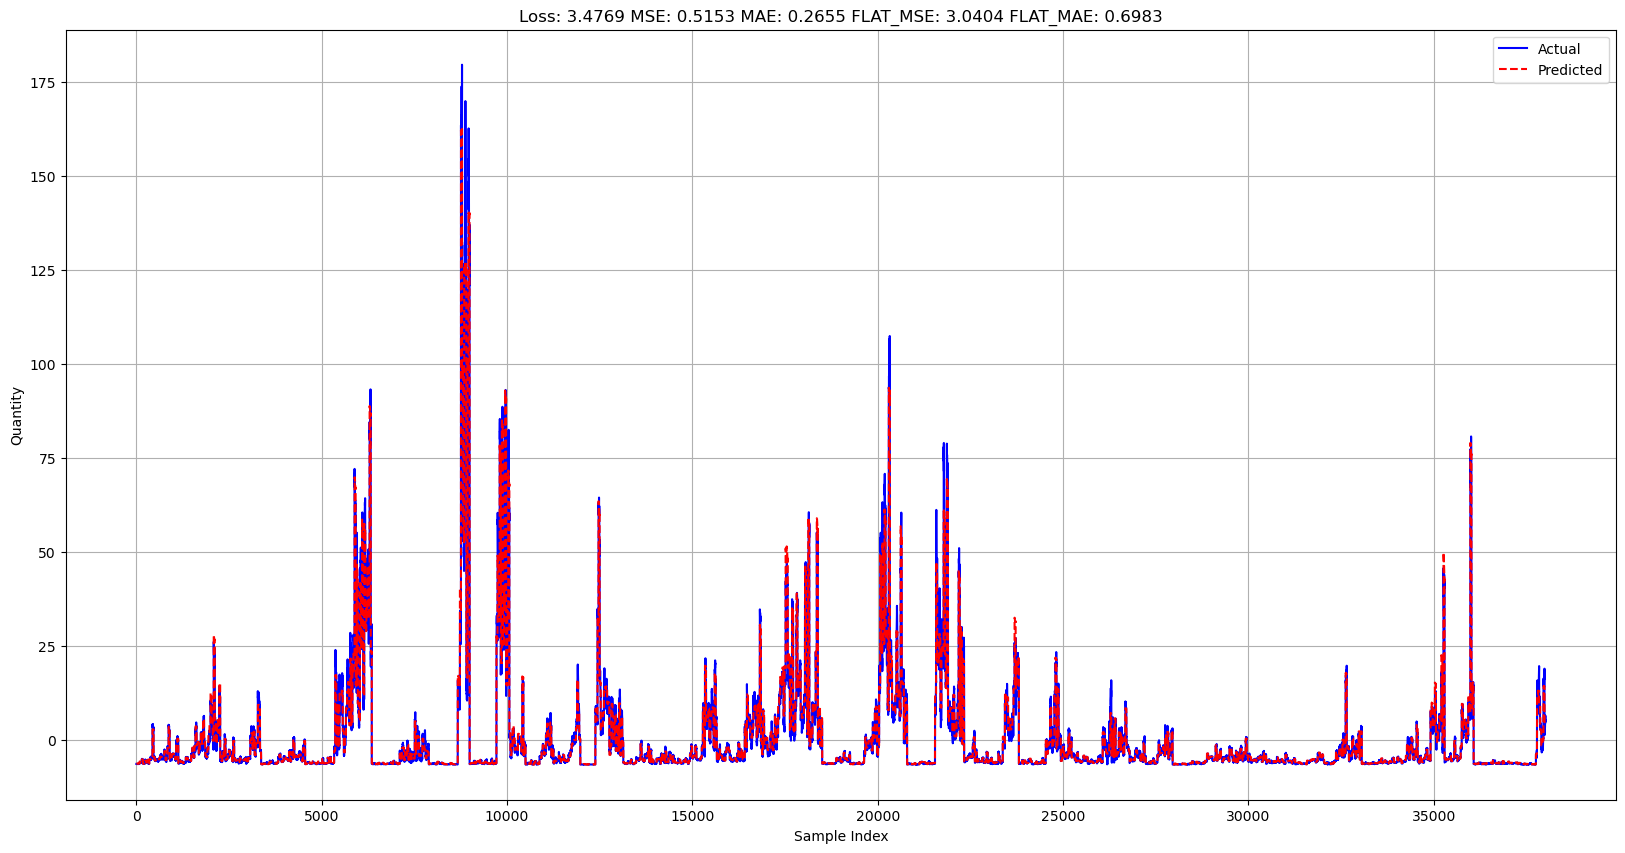

Validation Results:
Loss: 3.4769 MSE: 0.5153 MAE: 0.2655 FLAT_MSE: 3.0404 FLAT_MAE: 0.6983


In [55]:
# Validate the model on the test dataset
val_metrics = validate_model(
    model, dl_test, regression_criterion, classification_criterion, batch_size, True
)

In [56]:
score = round(val_metrics["metrics"]["MeanSquaredError"], 5)
torch.save(
    model,
    f"models/model_{best_params['flatten']}_{score}_{window}_{n_out}.pt",
)

In [57]:
predictions = scaler.inverse_transform(val_metrics["predictions"]).round()
actuals = scaler.inverse_transform(val_metrics["actuals"]).round()
flatten_predictions = np.sum(predictions, axis=-1)
flatten_actuals = np.sum(actuals, axis=-1)
d_preds = defaultdict(list)
sku_to_index_inv = {v: k for k, v in sku_to_index.items()}
for _pred, _y, _flatten_pred, _flatten_y, _sku in zip(
    predictions,
    actuals,
    flatten_predictions,
    flatten_actuals,
    [sku_to_index_inv[sku] for sku in val_metrics["skus"]],
):
    d_preds[_sku].append(
        {
            "preds": _pred,
            "y": _y,
            "flatten_preds": _flatten_pred,
            "flatten_y": _flatten_y,
            "preds_sum": _pred.sum(),
            "y_sum": _y.sum(),
        }
    )

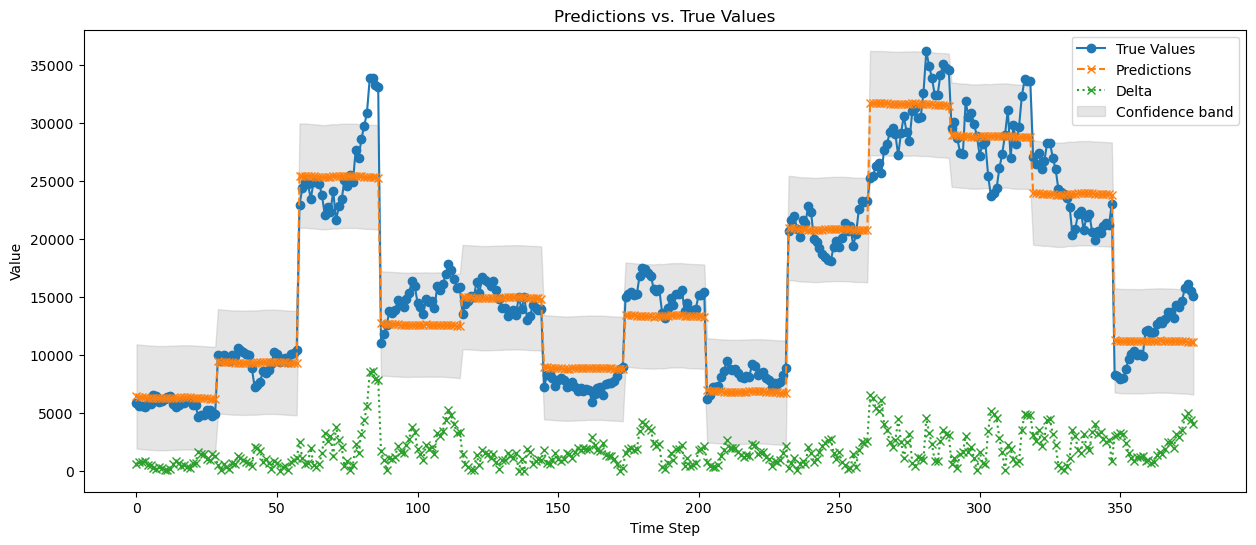

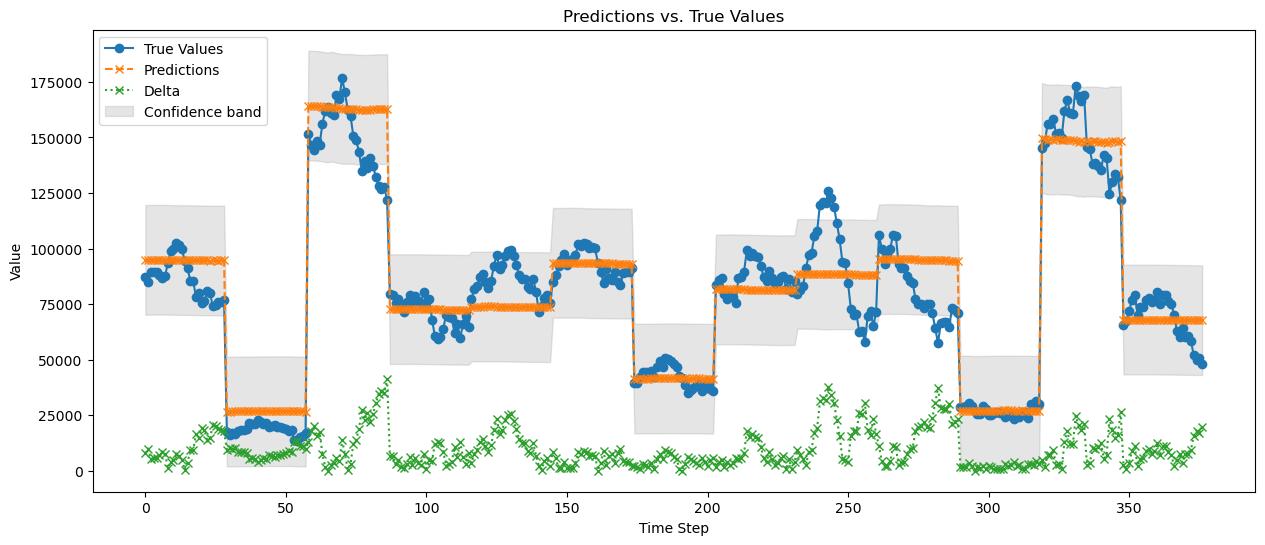

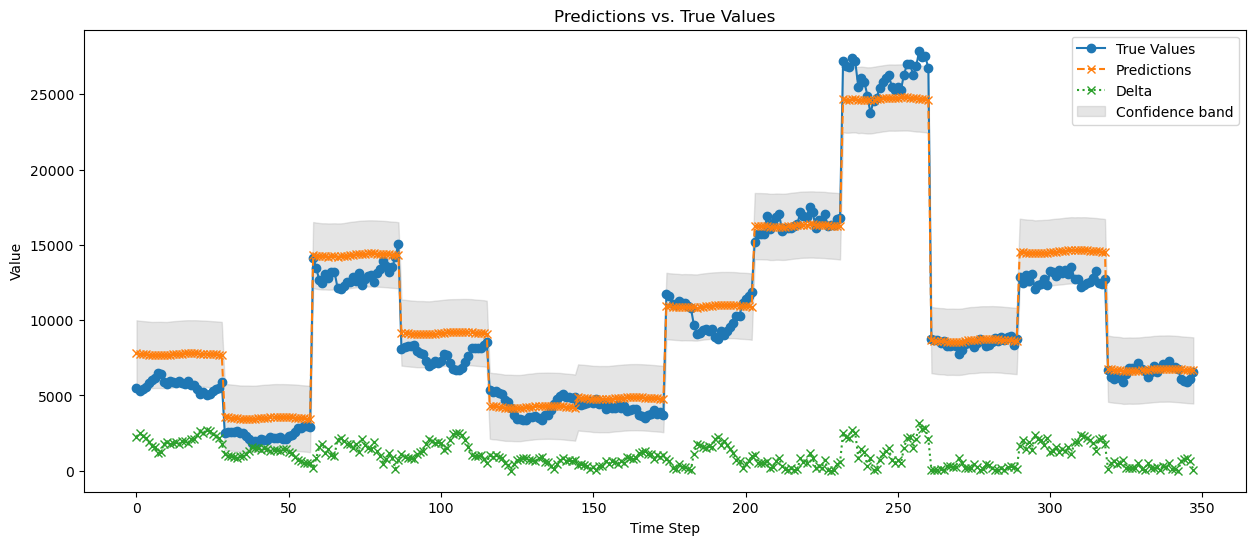

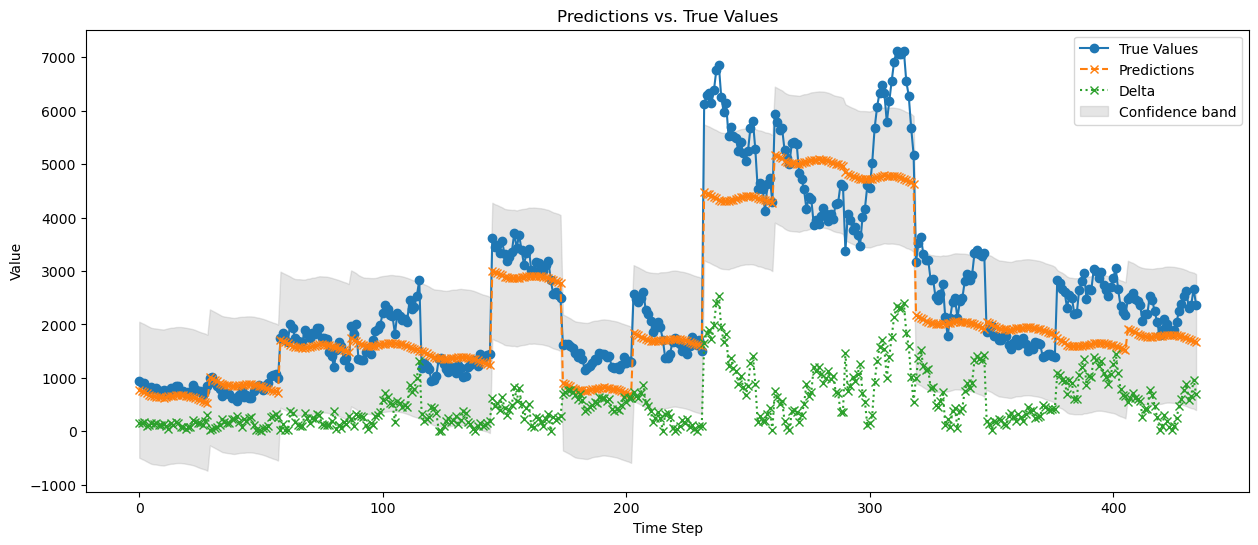

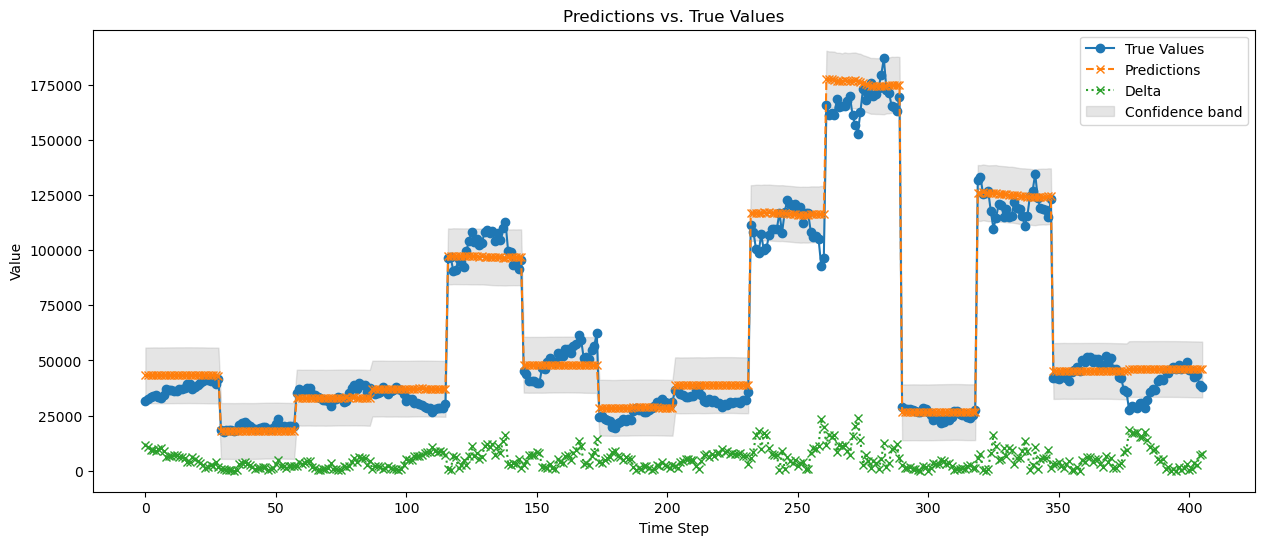

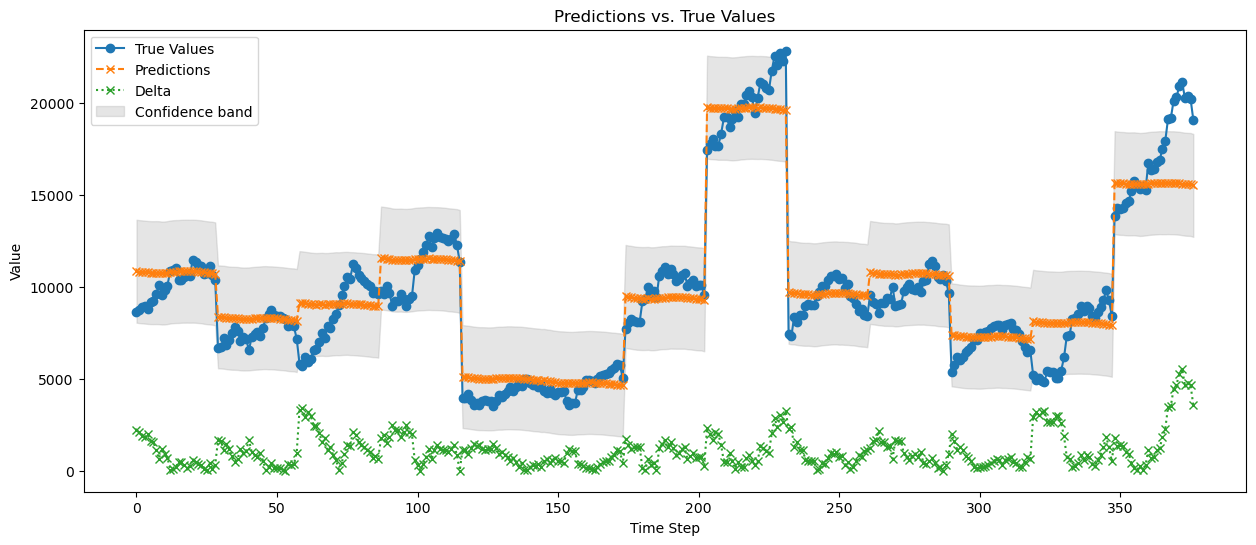

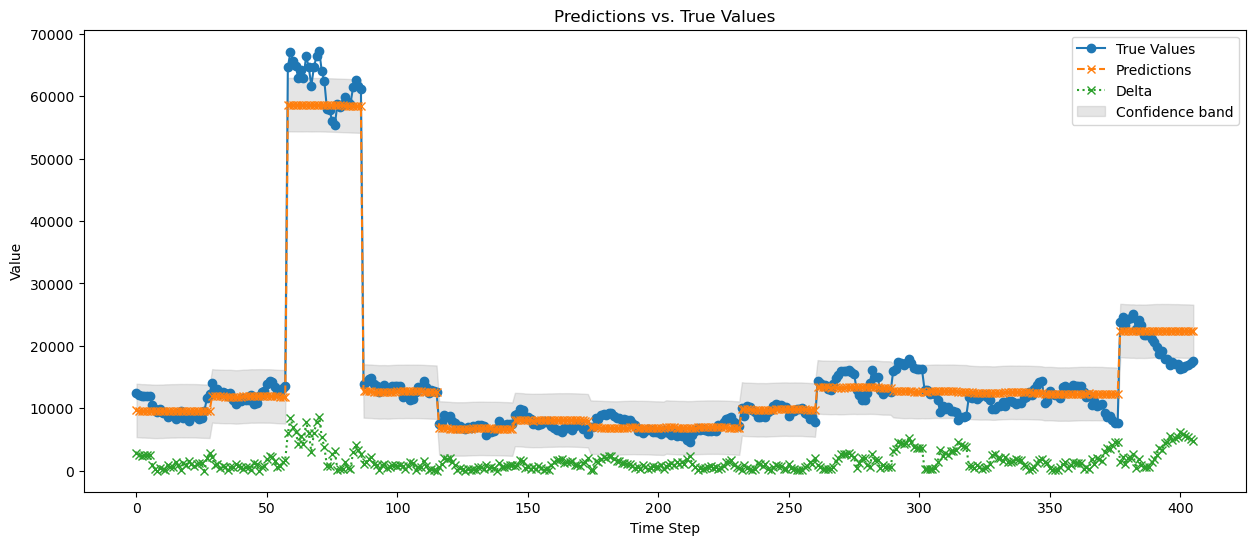

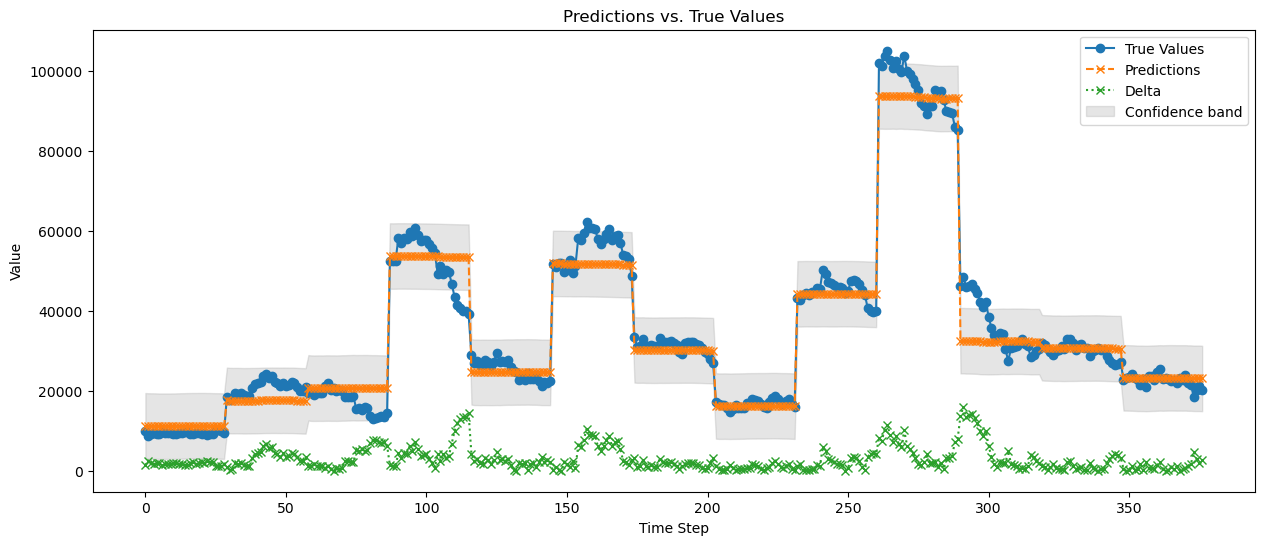

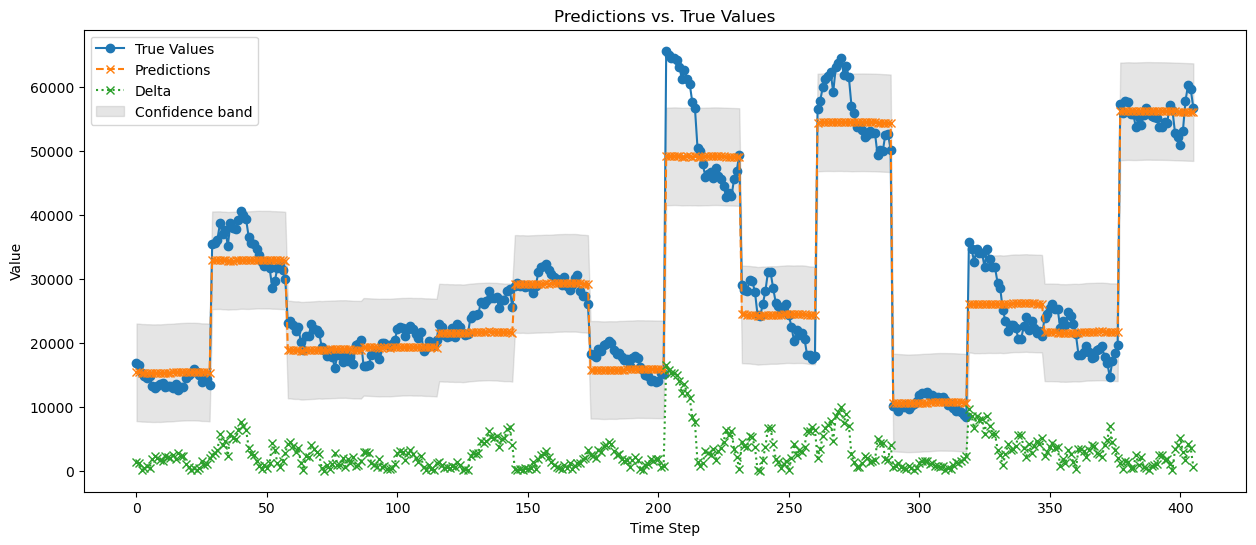

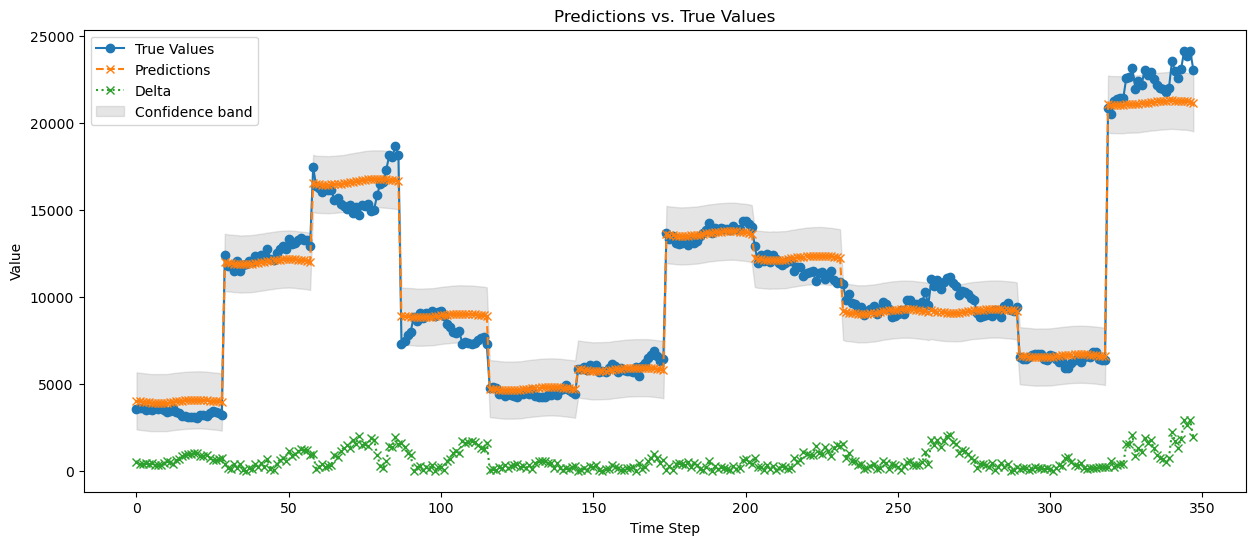

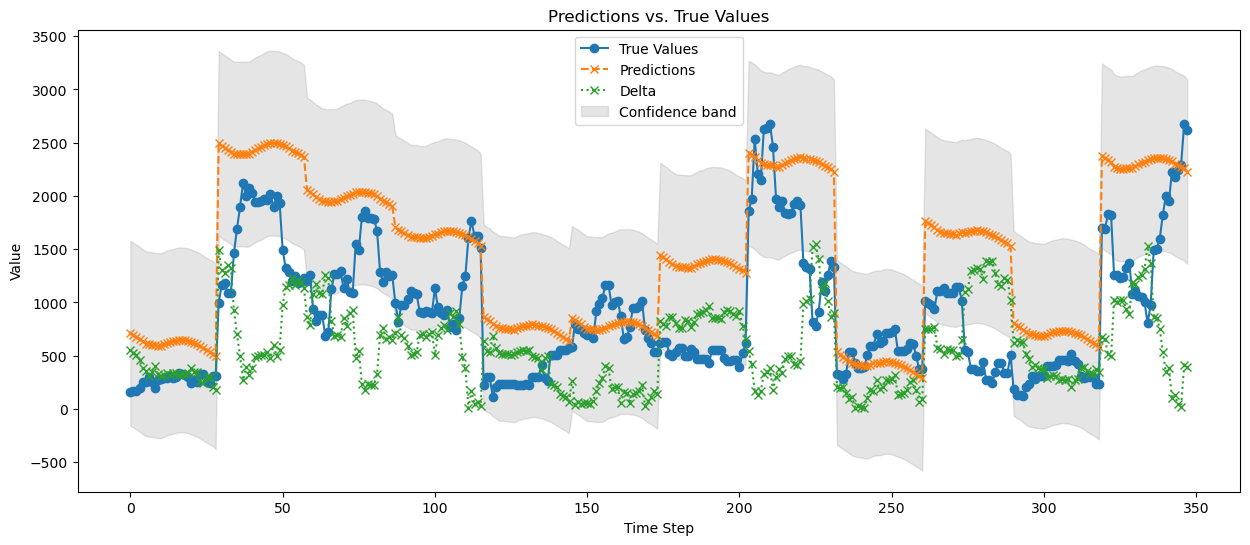

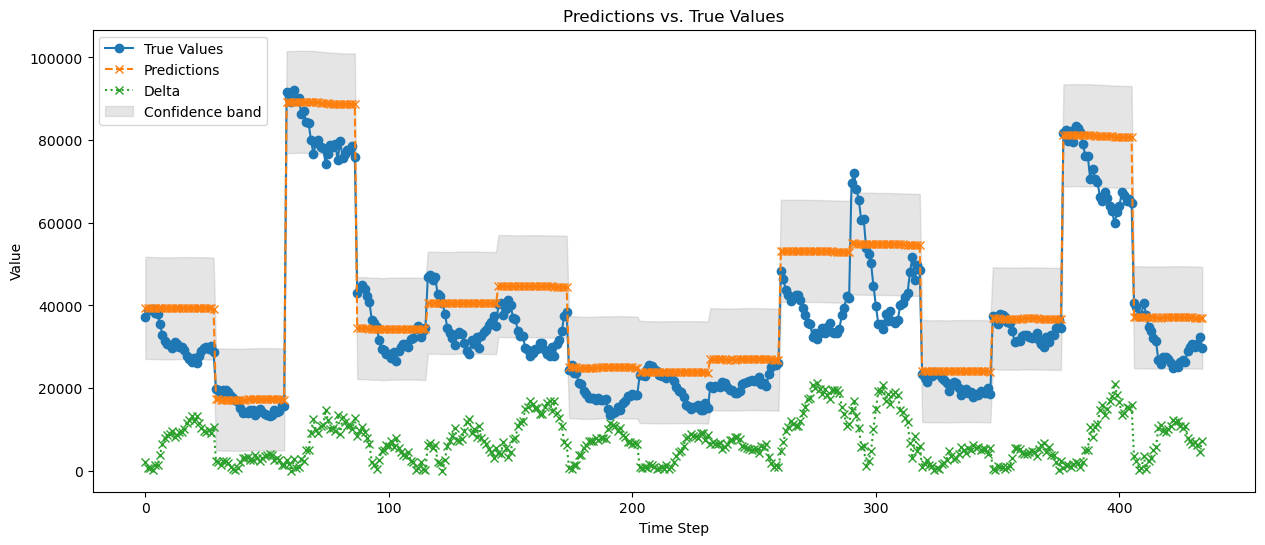

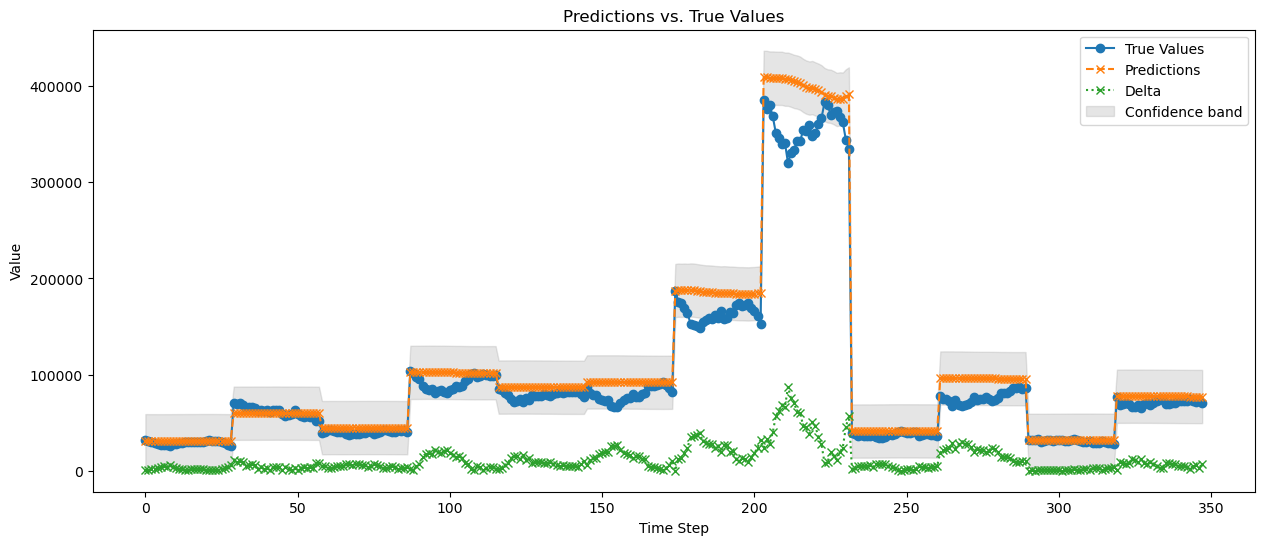

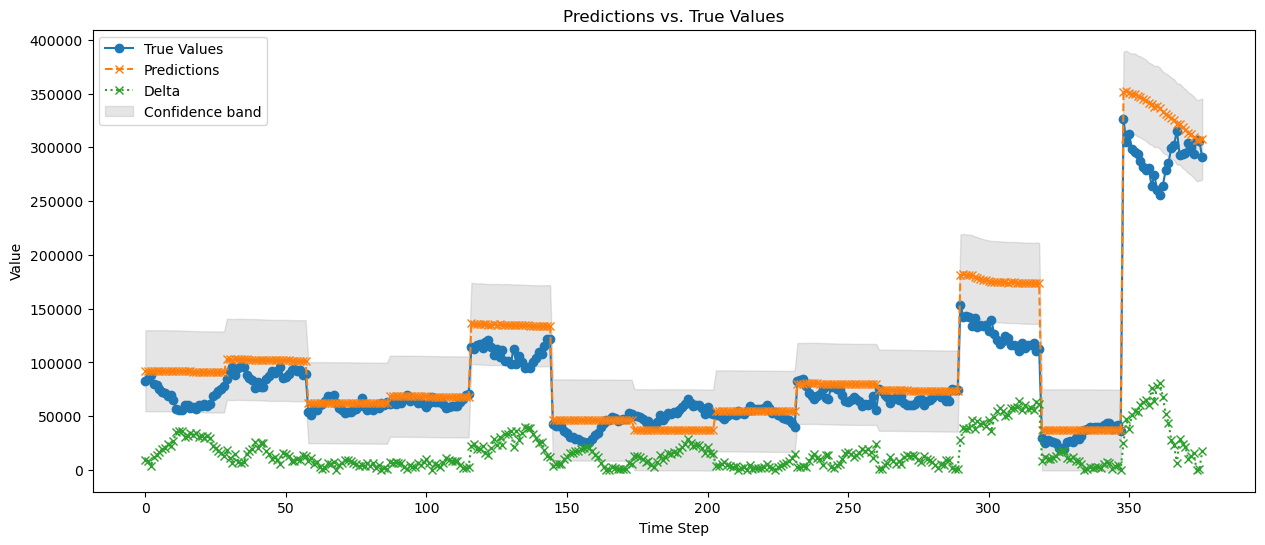

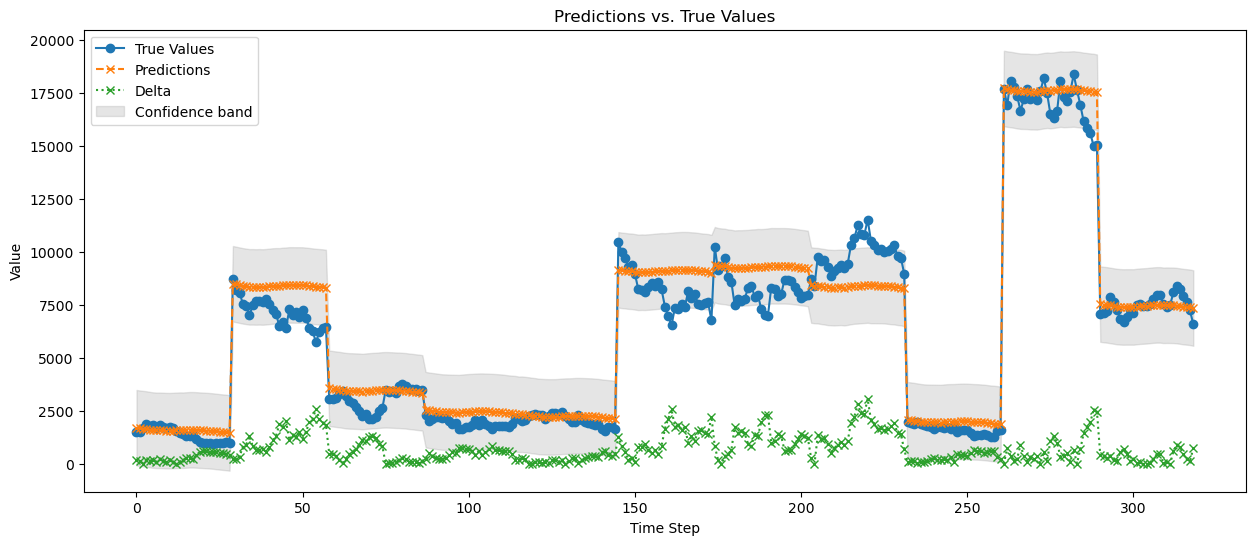

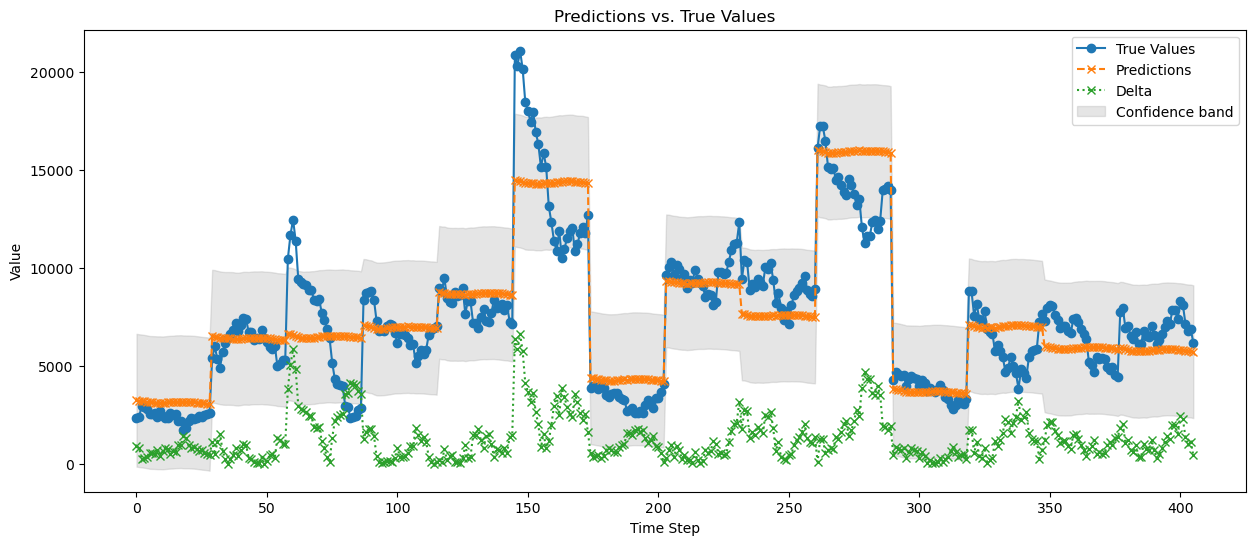

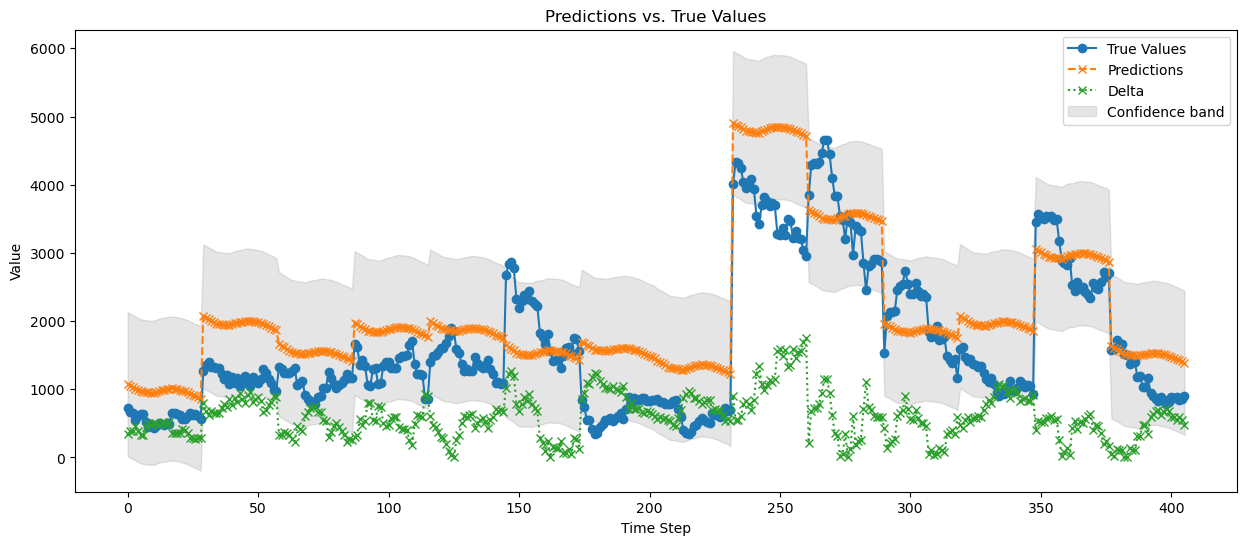

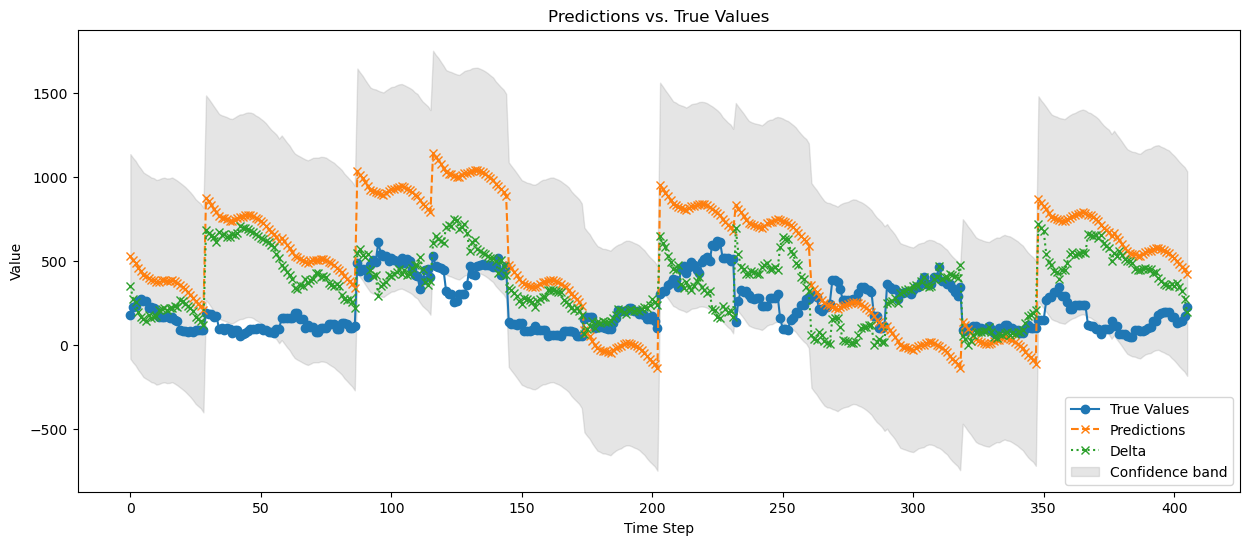

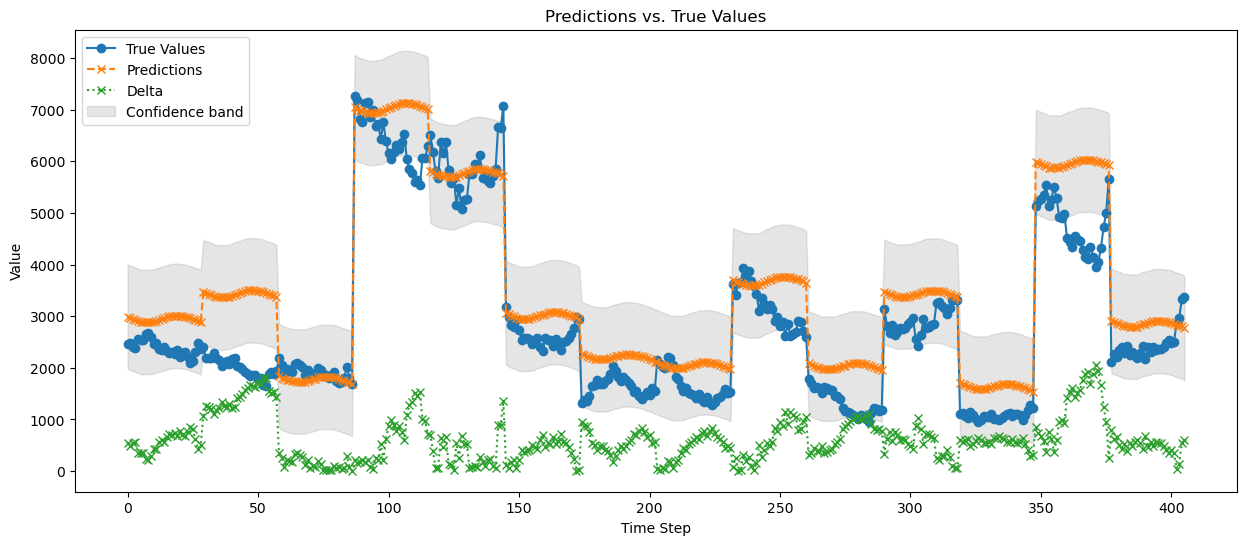

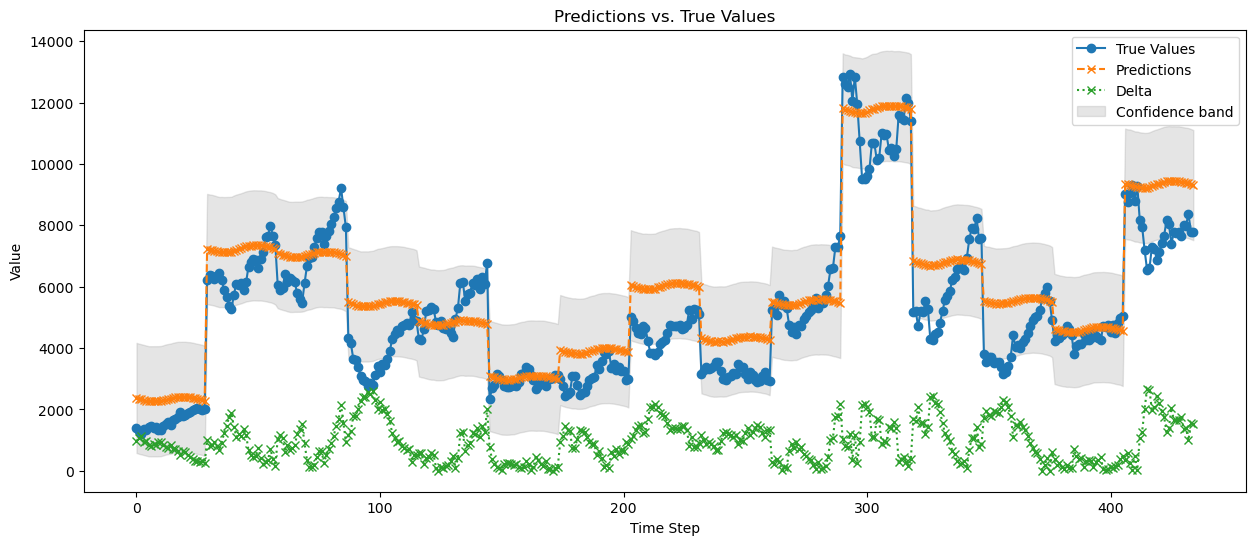

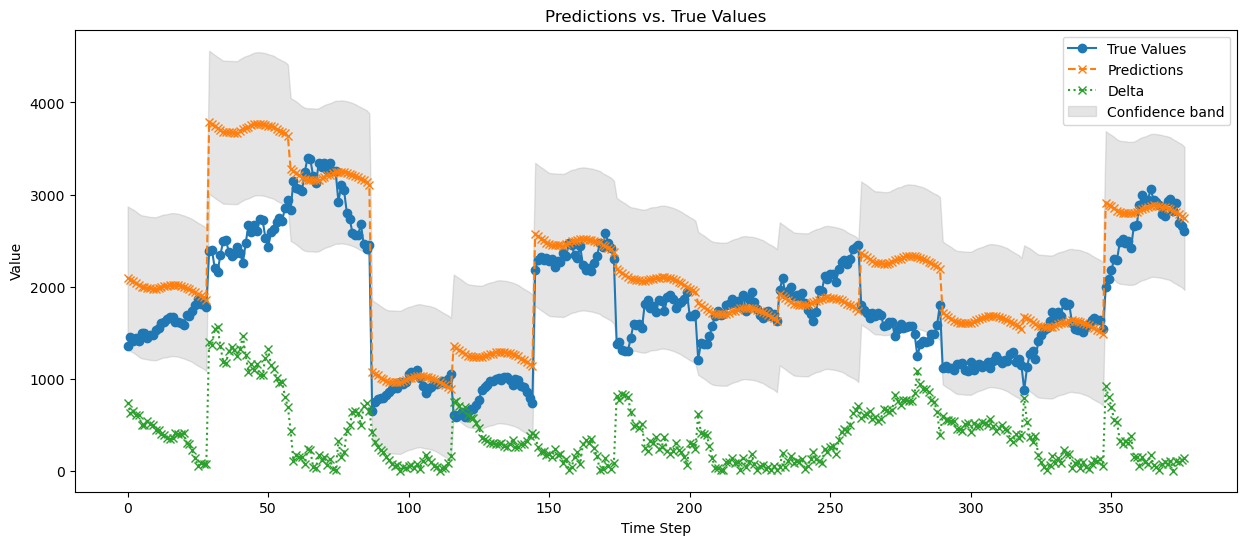

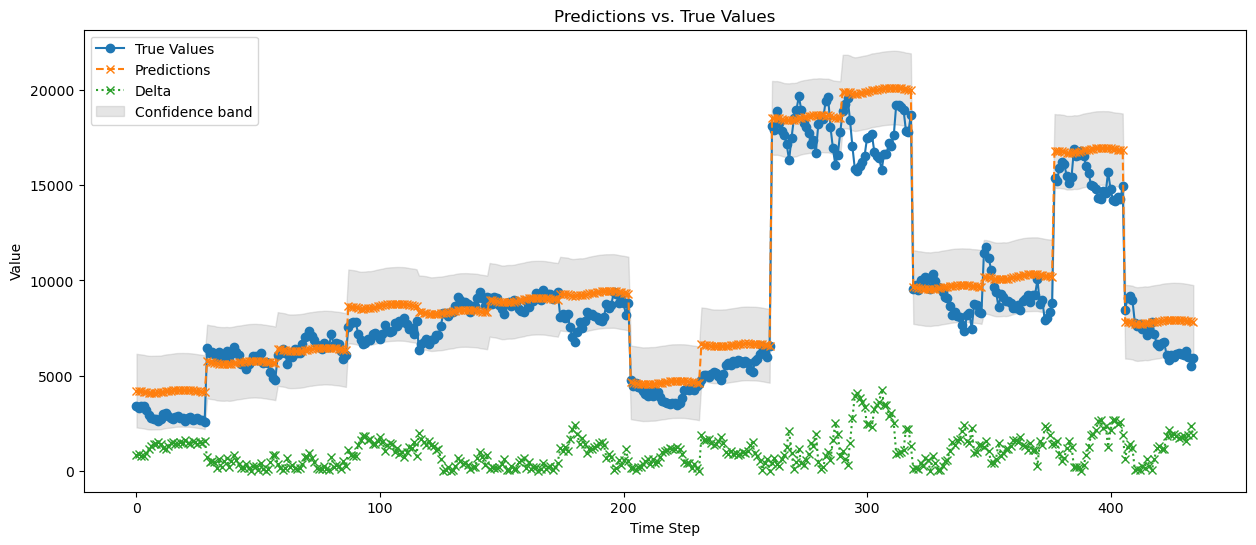

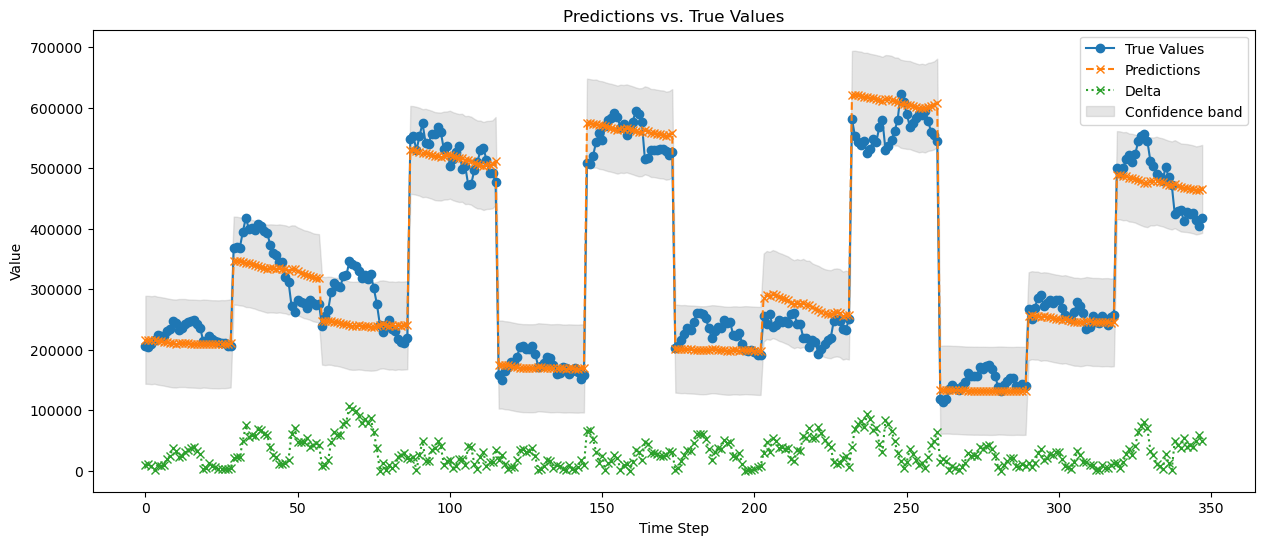

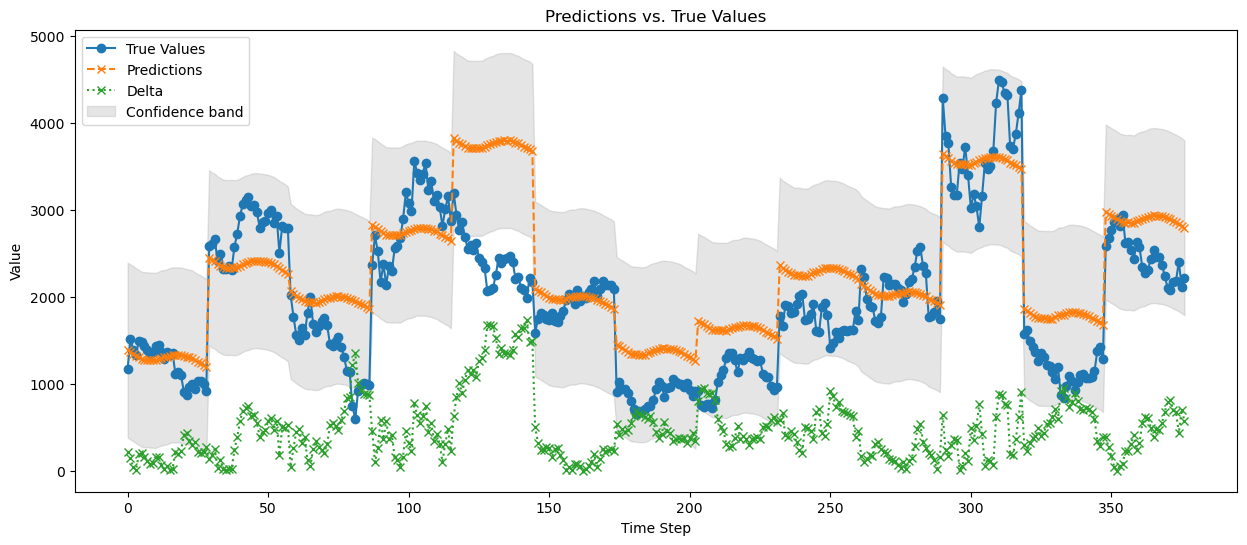

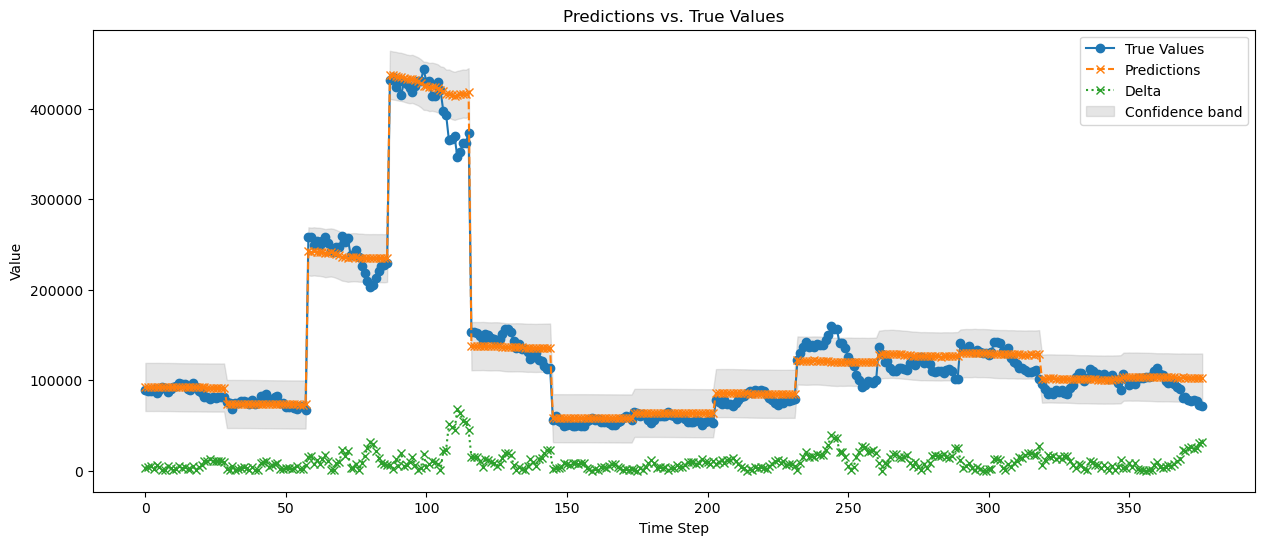

In [58]:
d_preds = list(d_preds.items())
random.shuffle(d_preds)
d_preds = dict(d_preds)
n = 0
plt.rcParams["figure.figsize"] = (15, 6)
for idx, (k, v) in enumerate(d_preds.items()):
    _v = pd.DataFrame(v)
    if len(_v["flatten_y"].unique()) <= 3:
        continue
    _v["delta"] = abs(_v["flatten_preds"] - _v["flatten_y"])
    x = range(0, len(_v))
    lower_bound, upper_bound = calculate_confidence_intervals(
        _v["flatten_preds"].values, _v["flatten_y"].values
    )
    plt.plot(x, _v["flatten_y"], label="True Values", marker="o", linestyle="-")
    plt.plot(x, _v["flatten_preds"], label="Predictions", marker="x", linestyle="--")
    plt.plot(x, _v["delta"], label="Delta", marker="x", linestyle=":")
    plt.fill_between(
        x, lower_bound, upper_bound, alpha=0.2, color="grey", label="Confidence band"
    )

    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title("Predictions vs. True Values")
    plt.legend()
    plt.show()

    n += 1
    if n >= 30:
        break

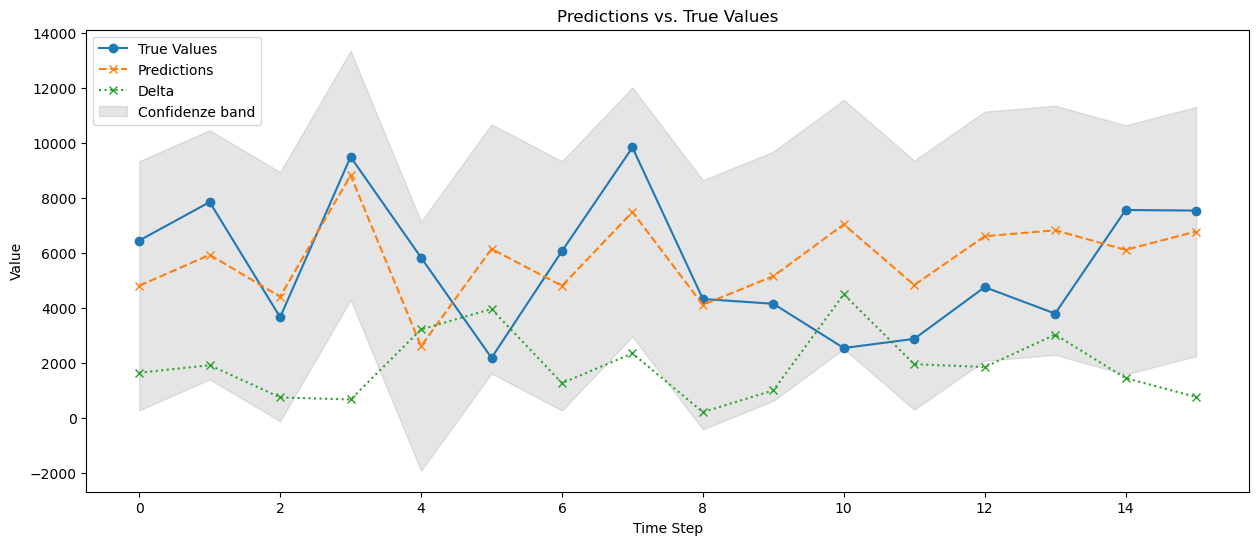

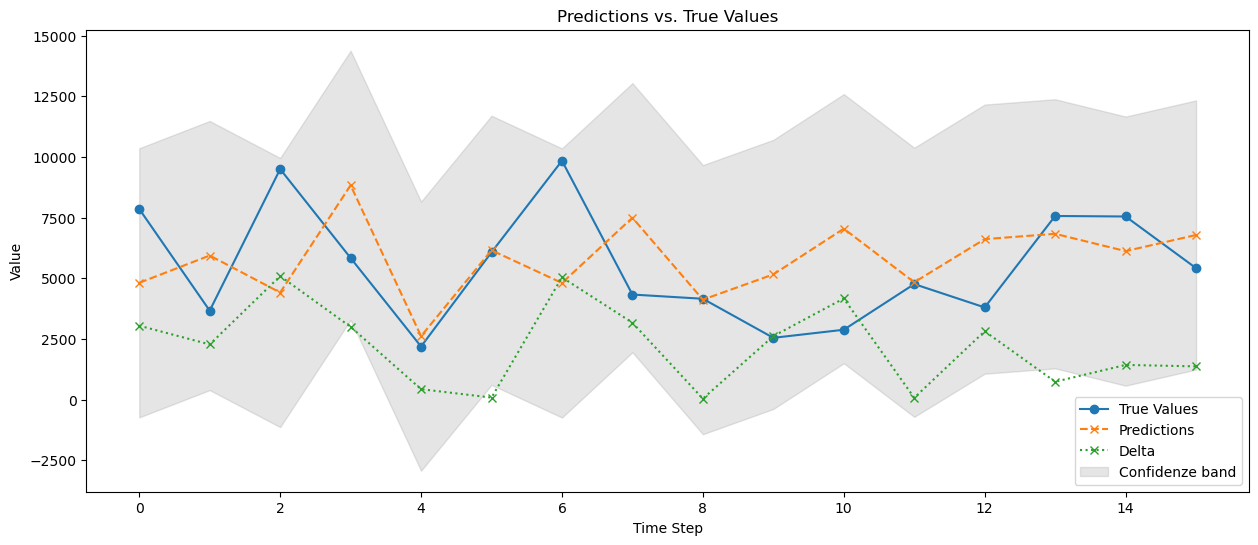

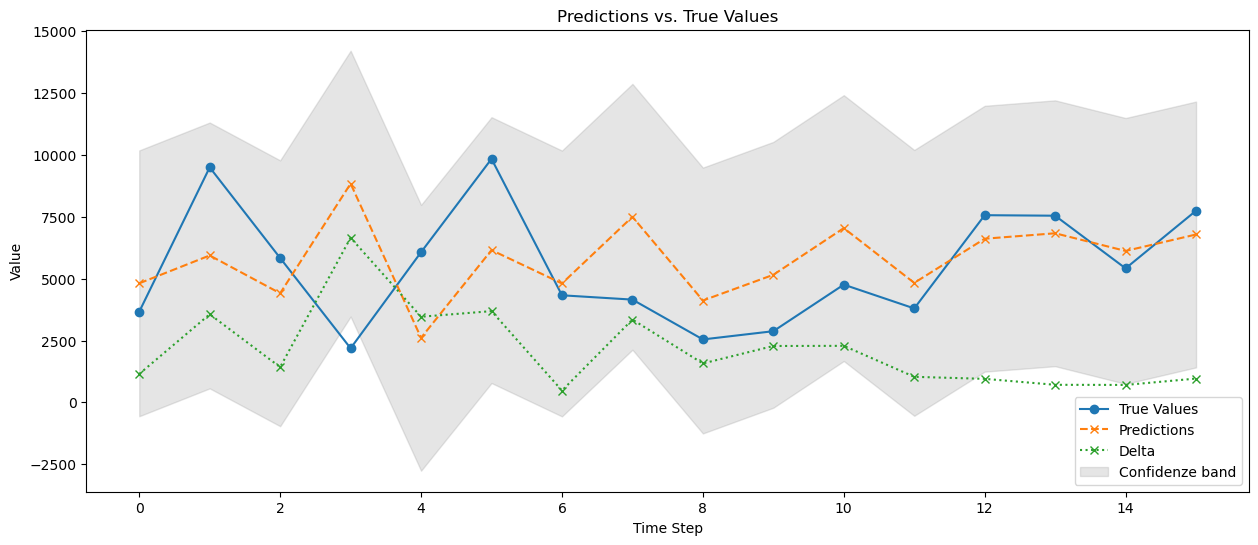

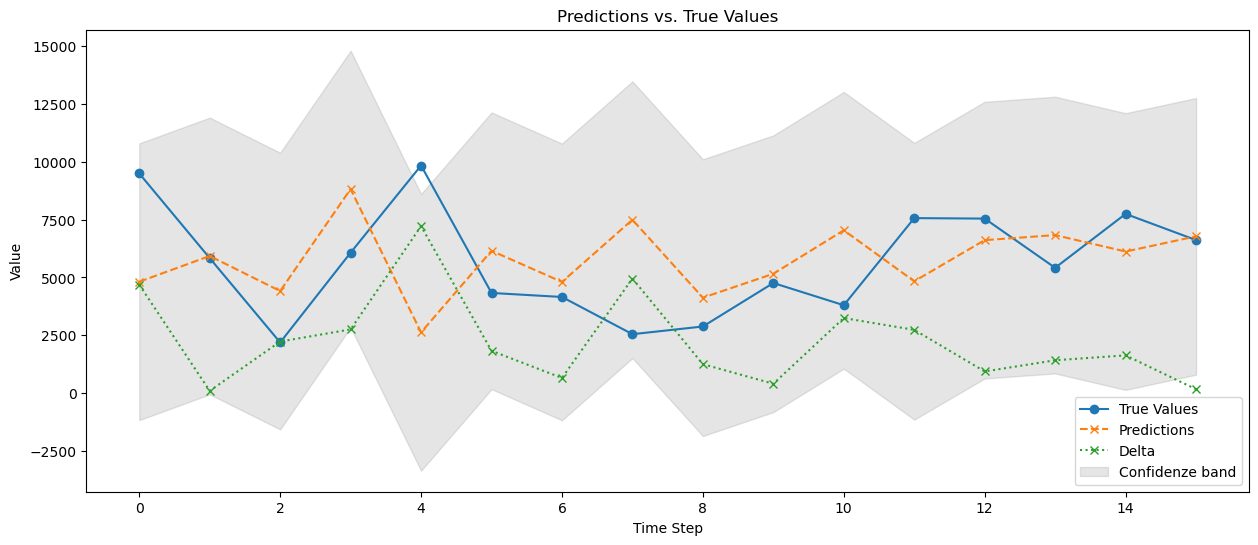

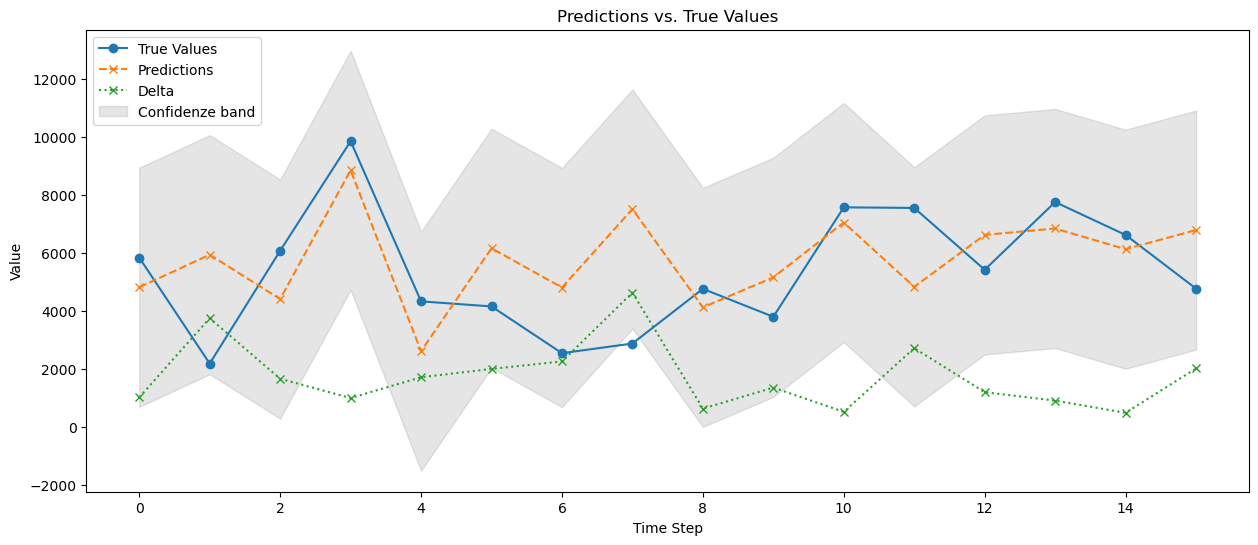

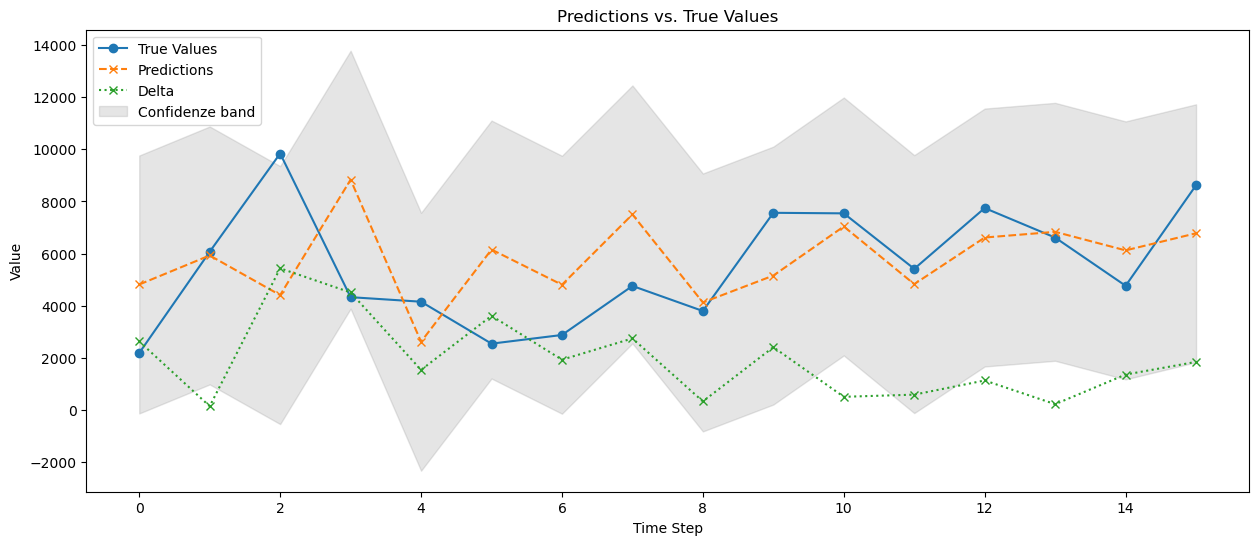

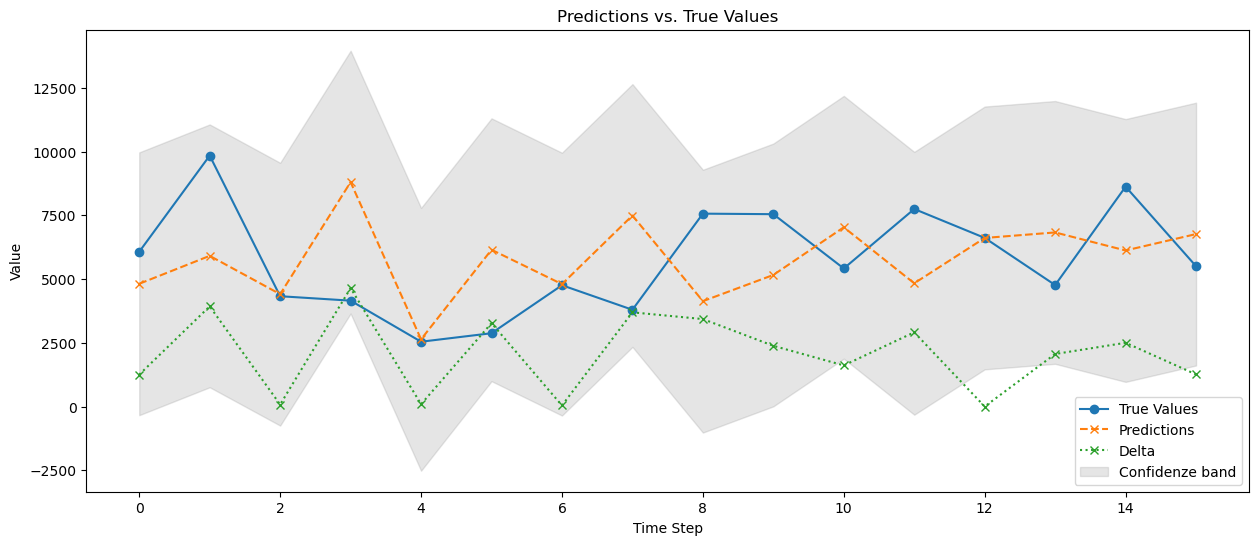

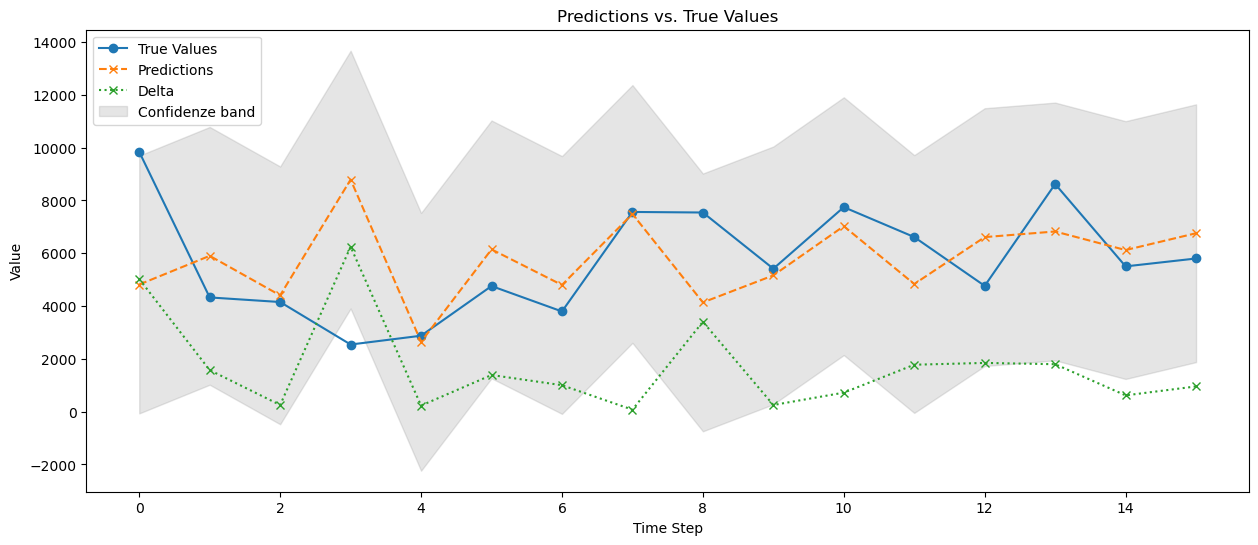

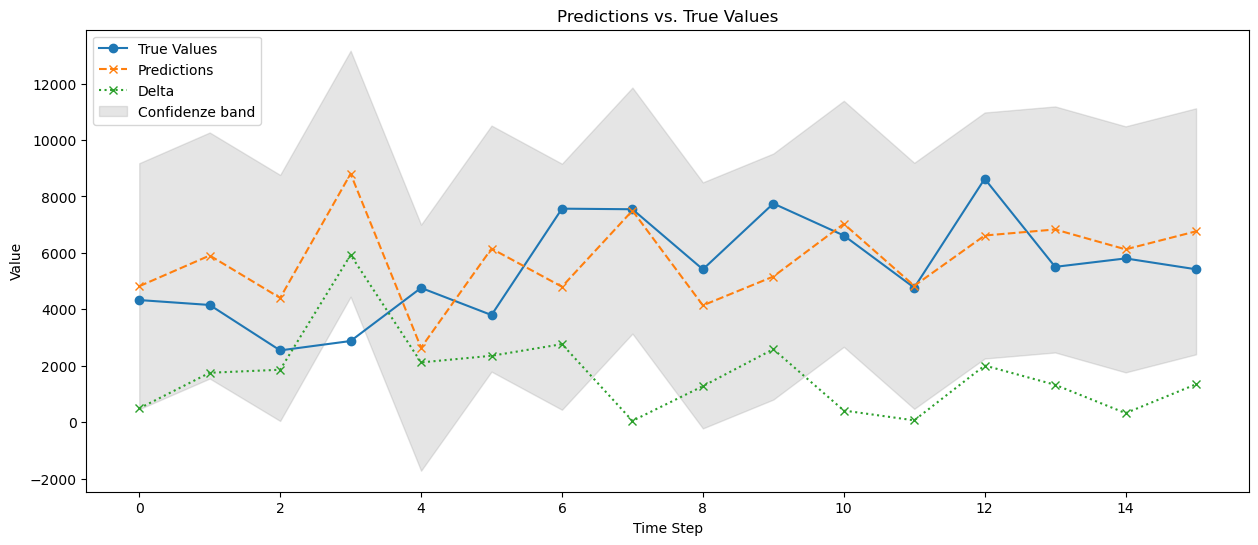

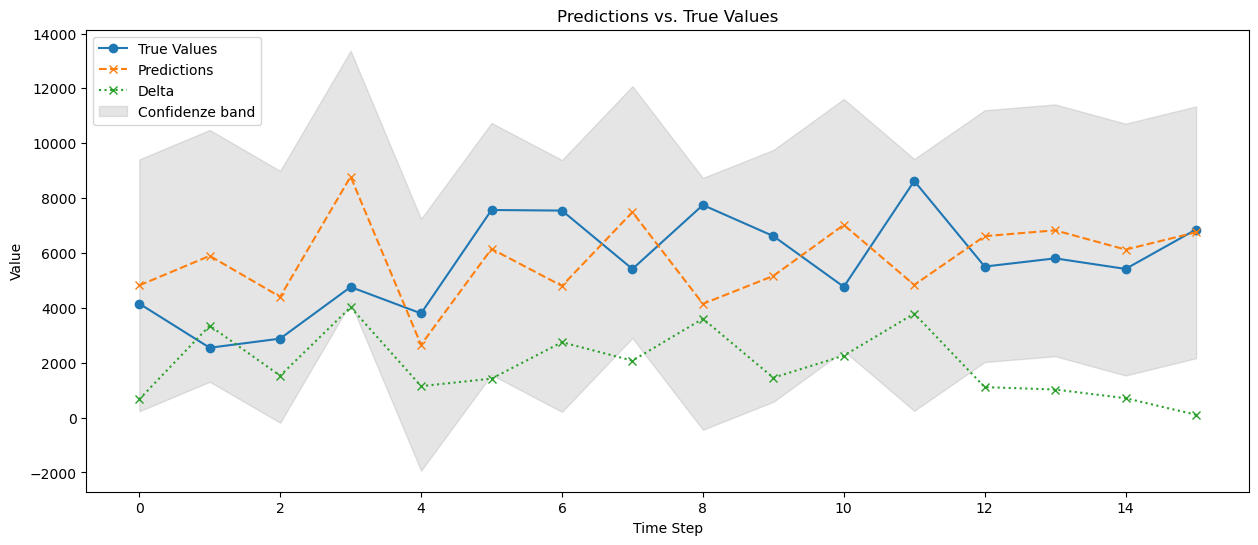

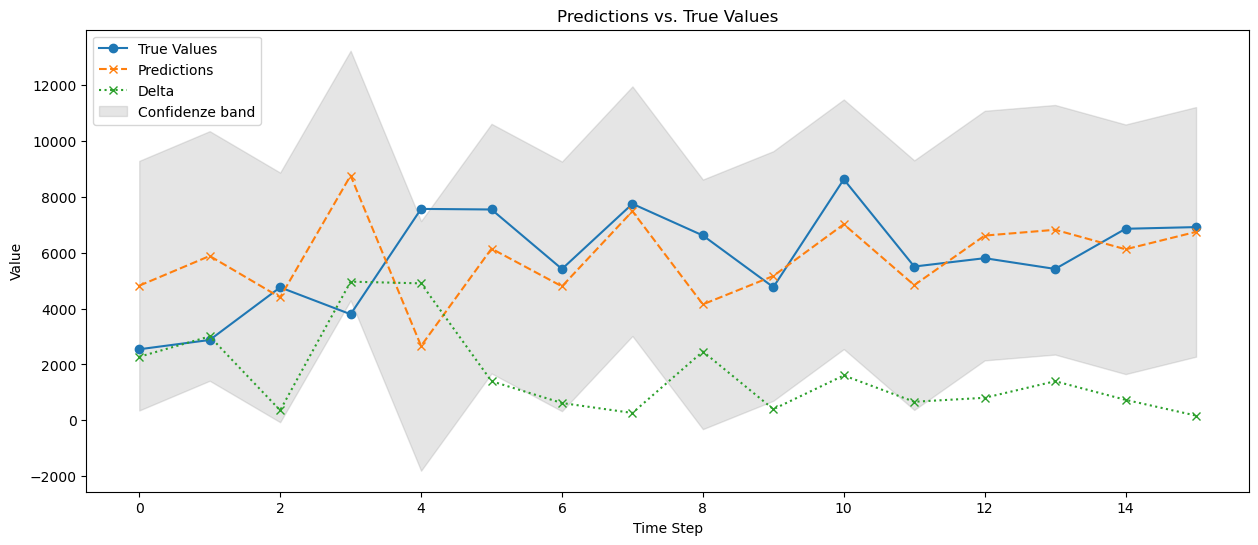

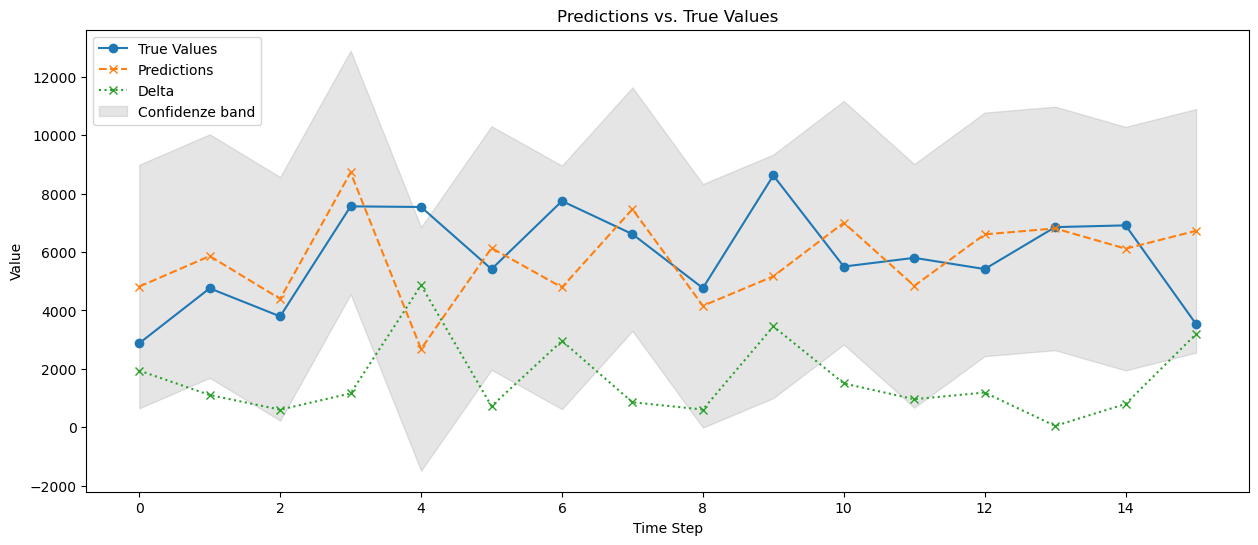

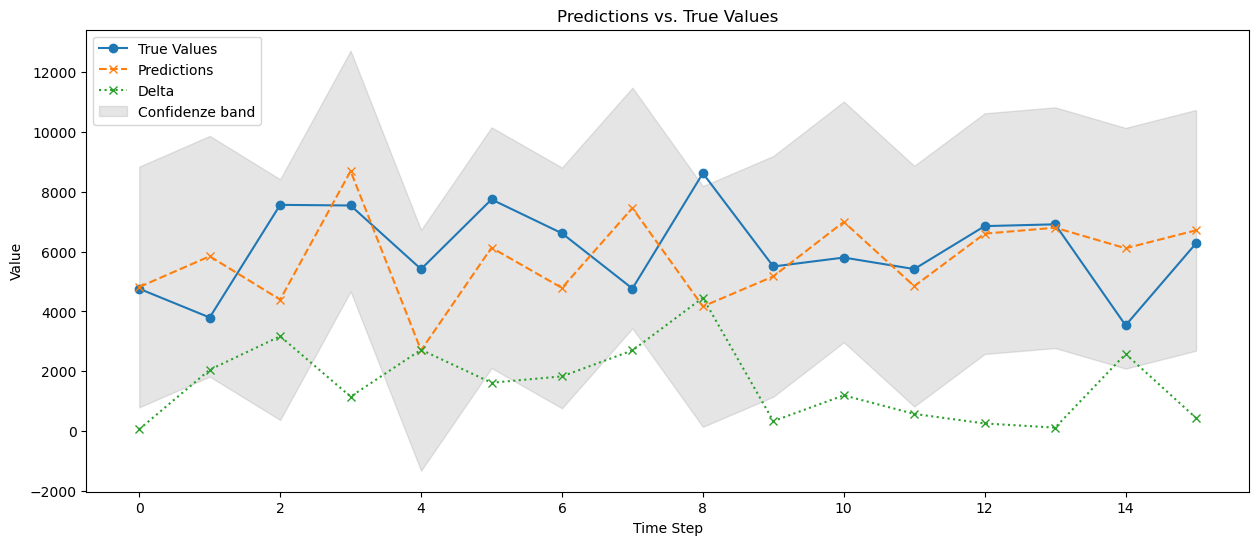

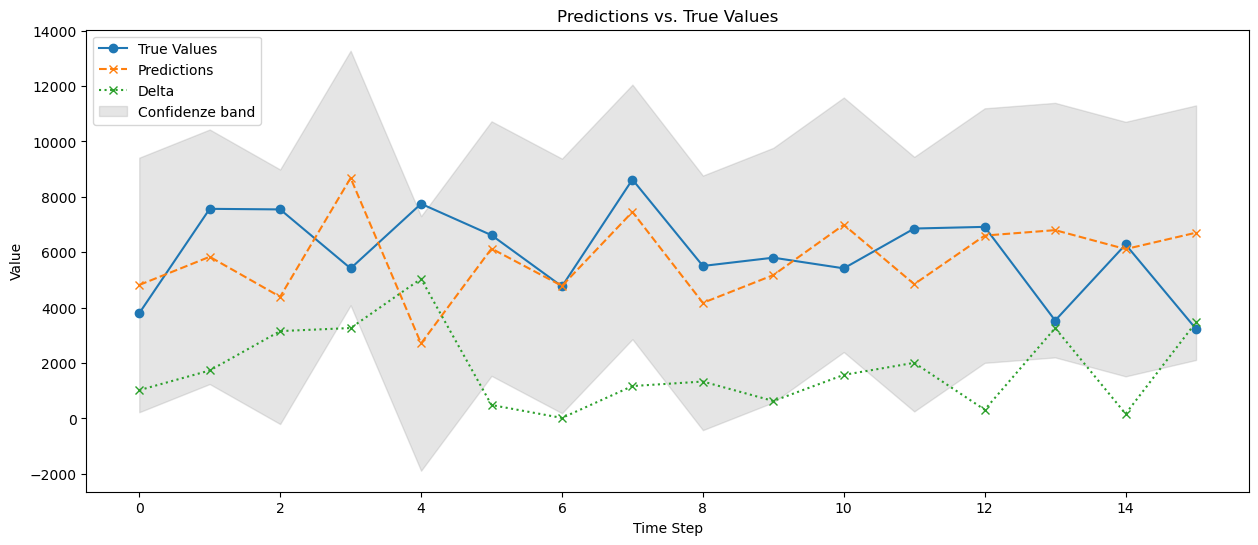

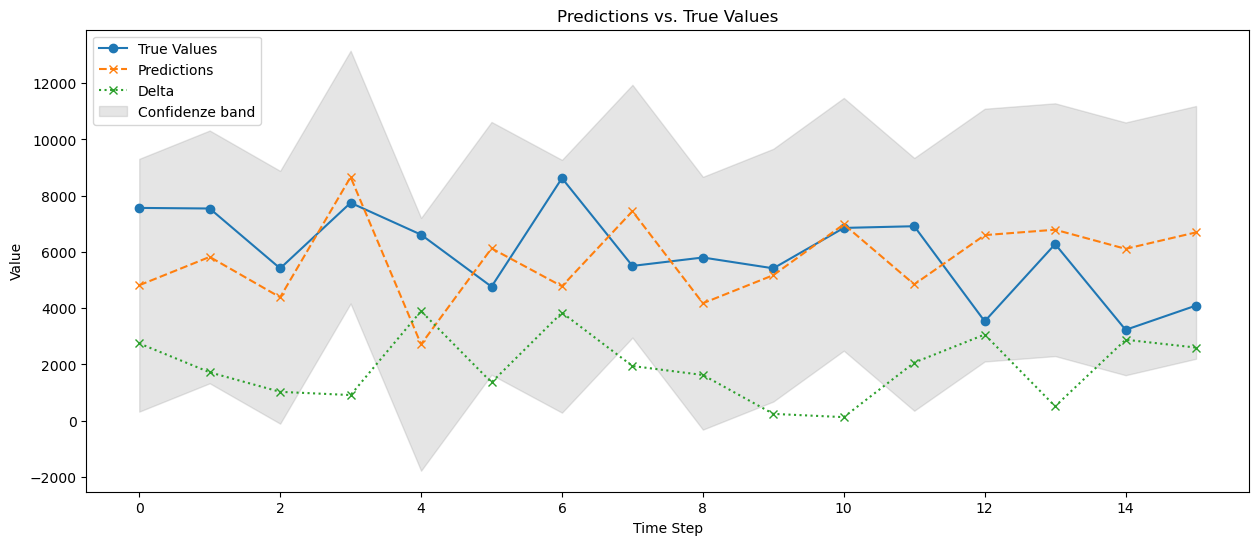

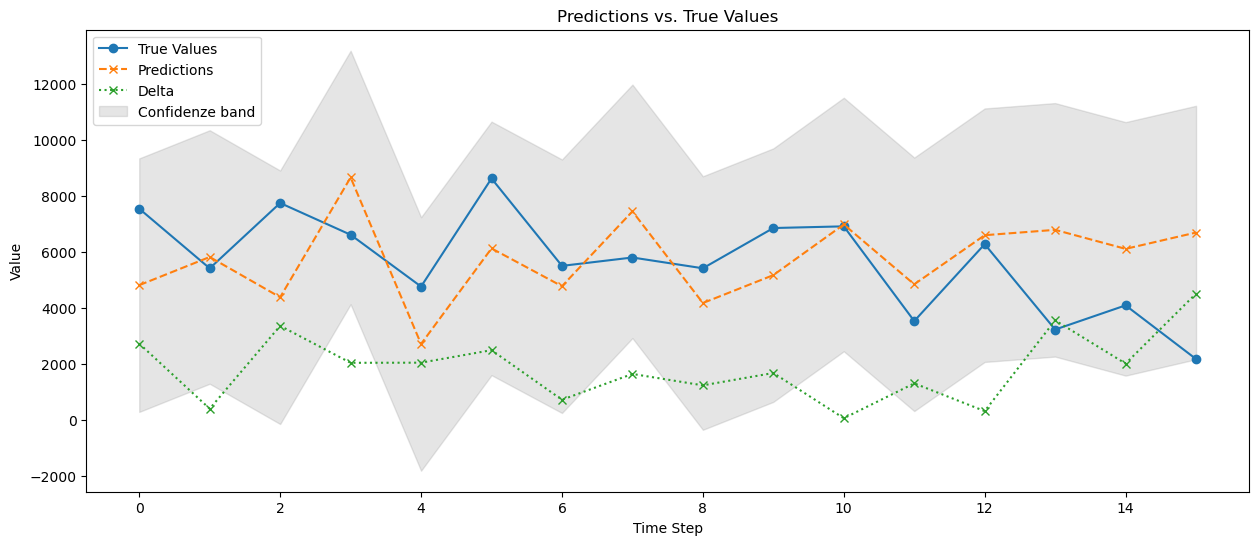

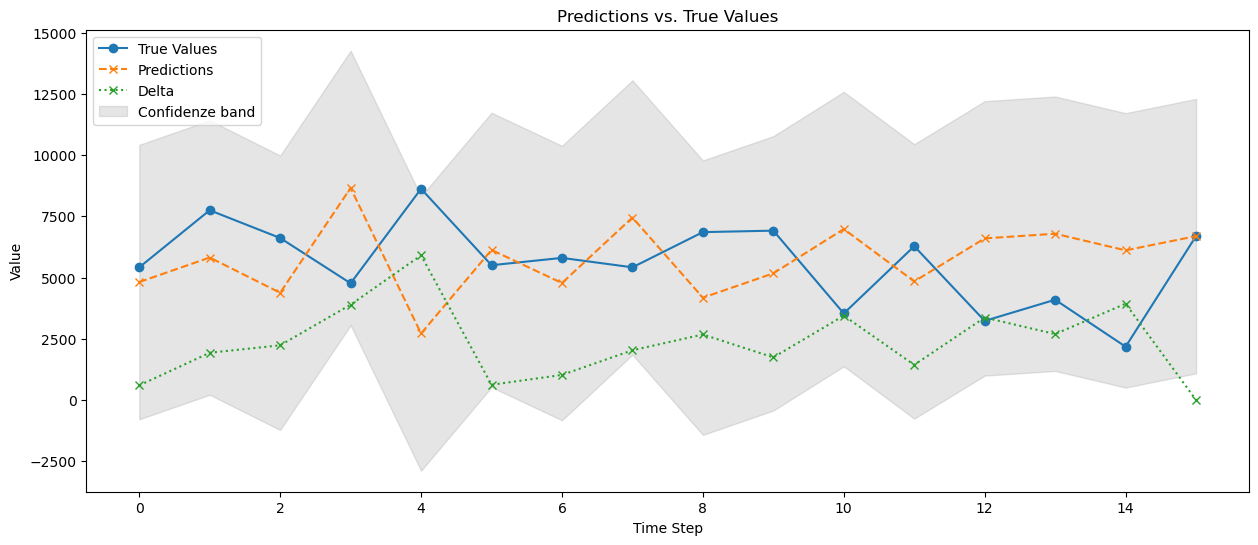

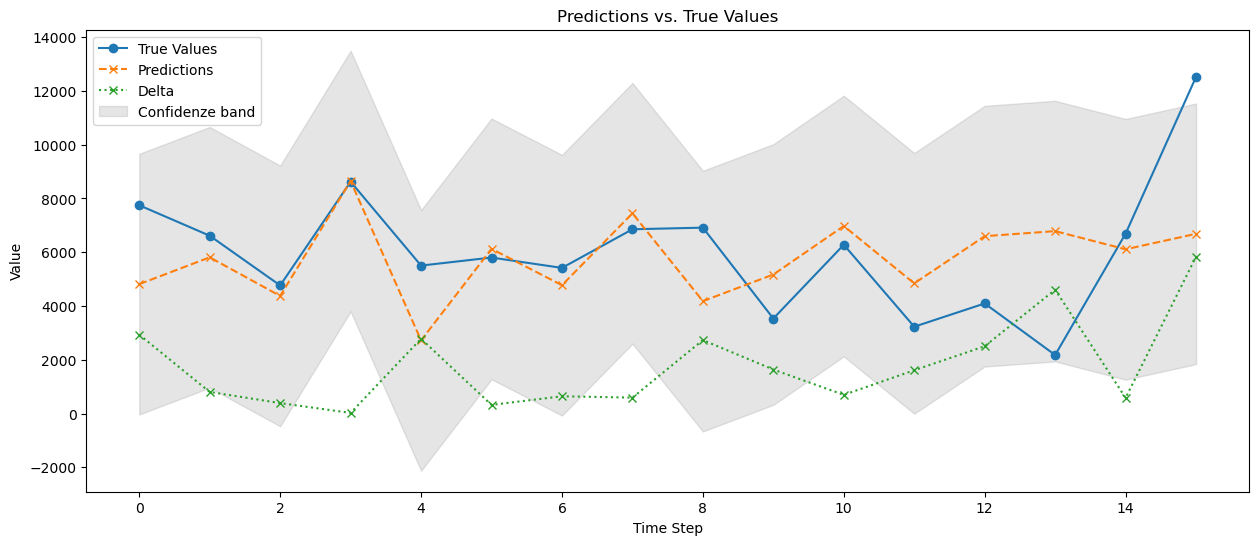

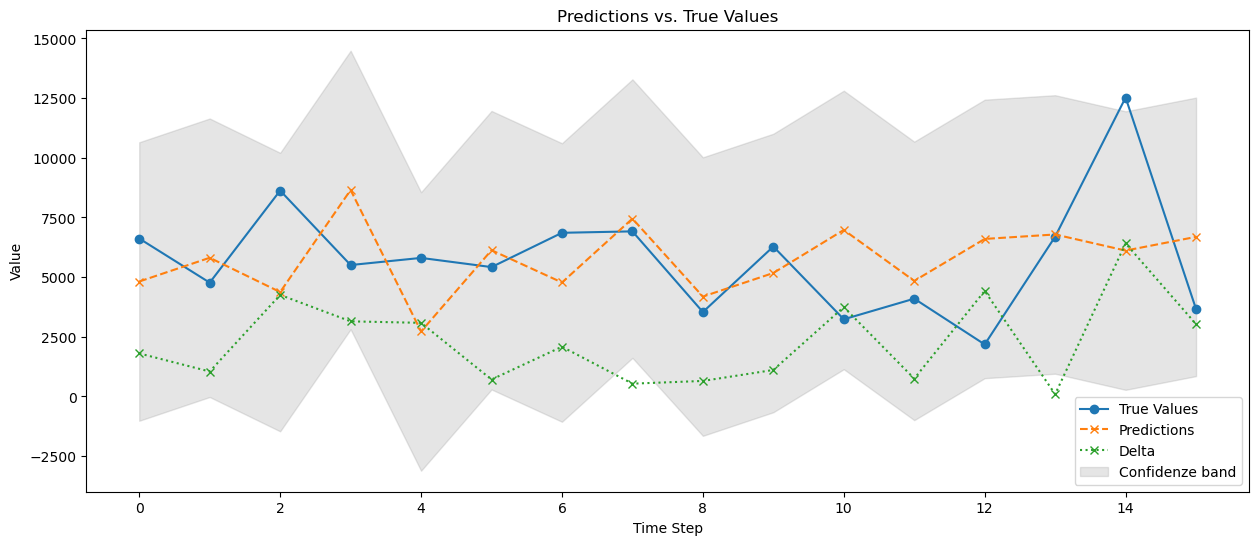

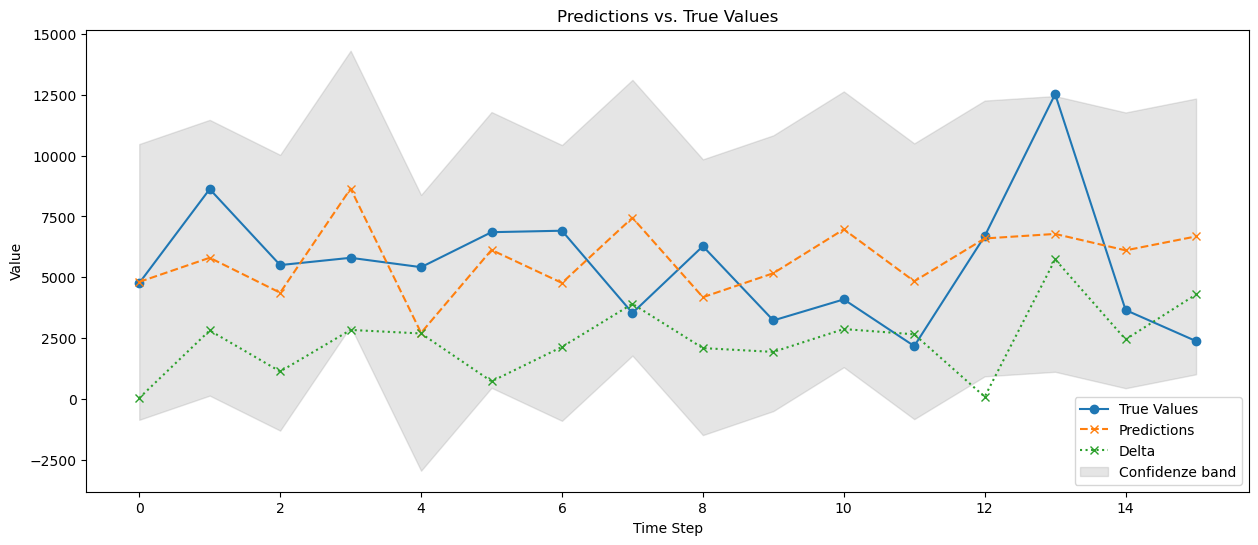

In [59]:
_v = pd.DataFrame(v)
n = 0
for _, row in _v.iterrows():
    x = list(range(len(row["y"])))
    lower_bound, upper_bound = calculate_confidence_intervals(row["preds"], row["y"])
    delta = abs(row["preds"] - row["y"])
    plt.plot(x, row["y"], label="True Values", marker="o", linestyle="-")
    plt.plot(x, row["preds"], label="Predictions", marker="x", linestyle="--")
    plt.plot(x, delta, label="Delta", marker="x", linestyle=":")
    plt.fill_between(
        x, lower_bound, upper_bound, alpha=0.2, color="grey", label="Confidenze band"
    )

    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title("Predictions vs. True Values")
    plt.legend()
    plt.show()
    n += 1
    if n >= 20:
        break